In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

In [3]:
import sys
import numpy
import logging
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import colorcet
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

sys.path.append("/supaharris-client")
from supaharrisclient.units import arcmin2parsec
from supaharrisclient.units import parsec2arcmin
from supaharrisclient.utils import suppress_stdout
from supaharrisclient.client import SupaHarrisClient

sys.path.append("/supaharris")
from utils import convert_gc_names_from_sh_to_any

sys.path.append("/limepy")
import limepy

logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

# Setup the observational data we'd like to use

In [4]:
## Parsers from Auriga project
# Harris (1996, 2010 ed.) --> various observations for 157 MW GCs
sys.path.append("/auriga/src")
from mw_m31_gc_observations import read_MWandM31_data
MW_h96e10, MW_v13, M31_c11, M31_cr16 = read_MWandM31_data()
logger.info("Harris (1996, 2010 ed.)")
logger.info("  Found {0} GCs".format(len(MW_h96e10)))
logger.info("  Available fields:\n    {0}".format(MW_h96e10.dtype))
logger.info("  Available clusters:\n    {0}".format(MW_h96e10["ID"].astype("U10")))

Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
Harris (1996, 2010 ed.)
  Found 157 GCs
  Available fields:
    [('ID', 'S10'), ('Name', 'S10'), ('RADEC', 'O'), ('LONLAT', 'O'), ('R_Sun', '<f8'), ('R_gc', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Rproj', '<f8'), ('f10', 'V10'), ('FeH', '<f8'), ('wt', '<i8'), ('EBminV', '<f8'), ('V_HB', '<f8'), ('mminMV', '<f8'), ('V_t', '<f8'), ('M_Vt', '<f8'), ('UminB', '<f8'), ('BminV', '<f8'), ('VminR', '<f8'), ('VminI', '<f8'), ('spt', 'S2'), ('ellip', '<f8'), ('f24', 'V10'), ('v_r', '<f8'), ('v_r_err', '<f8'), ('v_LSR', '<f8'), ('sig_v', '<f8'), ('sig_v_err', '<f8'), ('c', '<f8'), ('collapsed', 'S2'), ('r_c', '<f8'), ('r_h', '<f8'), ('mu_V', '<f8'), ('rho_0', '<f8'), ('lgtc', '<f8'), ('lgth', '<f8'), ('Mass', '<f8')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Ko 2'
 'Pyxis' 'NGC 2808' 'E

In [5]:
# Vandenberg (2013) --> Ages
dtype = numpy.dtype(MW_v13.dtype.descr + [("ID", "U10")])
bla = numpy.empty(MW_v13.shape, dtype=dtype)
bla[list(MW_v13.dtype.names)] = MW_v13
bla["ID"] = [convert_gc_names_from_sh_to_any(n, reverse=True) for n in ["NGC {0}".format(gc["NGC"])
    if gc["NGC"] != -1 else gc["Name"].astype("U10") for gc in MW_v13]]
MW_v13 = bla
logger.info("\nVandenberg (2013)")
logger.info("  Found {0} GCs".format(len(MW_v13)))
logger.info("  Available fields:\n    {0}".format(MW_v13.dtype))
logger.info("  Available clusters:\n    {0}".format(MW_v13["ID"]))


Vandenberg (2013)
  Found 55 GCs
  Available fields:
    [('NGC', '<i8'), ('Name', 'S10'), ('FeH', '<f8'), ('Age', '<f8'), ('fAge', '<f8'), ('Method', 'S1'), ('Fig', 'S5'), ('Range', 'S12'), ('HBType', '<f8'), ('R_GC', '<f8'), ('M_V', '<f8'), ('v_e0', '<f8'), ('log10sigma0', '<f8'), ('Rproj', '<f8'), ('ID', '<U10')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'NGC 1261' 'NGC 1851' 'NGC 2808' 'NGC 3201'
 'NGC 4147' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053' 'NGC 5272'
 'NGC 5286' 'NGC 5466' 'NGC 5904' 'NGC 5927' 'NGC 5986' 'NGC 6101'
 'NGC 6121' 'NGC 6144' 'NGC 6171' 'NGC 6205' 'NGC 6218' 'NGC 6254'
 'NGC 6304' 'NGC 6341' 'NGC 6352' 'NGC 6362' 'NGC 6366' 'NGC 6397'
 'NGC 6496' 'NGC 6535' 'NGC 6541' 'NGC 6584' 'NGC 6624' 'NGC 6637'
 'NGC 6652' 'NGC 6656' 'NGC 6681' 'NGC 6715' 'NGC 6717' 'NGC 6723'
 'NGC 6752' 'NGC 6779' 'NGC 6809' 'NGC 6838' 'NGC 6934' 'NGC 6981'
 'NGC 7078' 'NGC 7089' 'NGC 7099' 'Arp 2' 'Pal 12' 'Terzan 8']


In [6]:
## Parsers from Supaharris project
# Harris (1996, 2010 ed.)
from data.parse_harris_1996ed2010 import parse_harris1996ed2010
h96_gc = parse_harris1996ed2010(logger)
logger.info("\nHarris (1996, 2010ed.) SupaHarris parser")
logger.info("  Found {0} GCs".format(len(h96_gc)))
logger.info("  Available fields:\n    {0}".format([k for k in vars(h96_gc["NGC 104"]).keys()]))
logger.info("  Available clusters:\n    {0}".format([gc for gc in h96_gc.keys()]))


Harris (1996, 2010ed.) SupaHarris parser
  Found 157 GCs
  Available fields:
    ['logger', 'gid', 'name', 'ra', 'dec', 'longitude', 'latitude', 'dist_from_sun', 'dist_from_gal_cen', 'X', 'Y', 'Z', 'metallicity', 'w_mean_met', 'eb_v', 'v_hb', 'app_vd_mod', 'v_t', 'm_v_t', 'ph_u_b', 'ph_b_v', 'ph_v_r', 'ph_v_i', 'spt', 'ellipticity', 'v_r', 'v_r_err', 'c_LSR', 'sig_v', 'sig_v_err', 'sp_c', 'sp_r_c', 'sp_r_h', 'sp_mu_V', 'sp_rho_0', 'sp_lg_tc', 'sp_lg_th', 'sig_err', 'rho_0', 'lg_tc', 'lg_th']
  Available clusters:
    ['NGC 104', 'NGC 288', 'NGC 362', 'Whiting 1', 'NGC 1261', 'Pal 1', 'AM 1', 'Eridanus', 'Pal 2', 'NGC 1851', 'NGC 1904', 'NGC 2298', 'NGC 2419', 'Ko 2', 'Pyxis', 'NGC 2808', 'E 3', 'Pal 3', 'NGC 3201', 'Pal 4', 'Ko 1', 'NGC 4147', 'NGC 4372', 'Rup 106', 'NGC 4590', 'NGC 4833', 'NGC 5024', 'NGC 5053', 'NGC 5139', 'NGC 5272', 'NGC 5286', 'AM 4', 'NGC 5466', 'NGC 5634', 'NGC 5694', 'IC 4499', 'NGC 5824', 'Pal 5', 'NGC 5897', 'NGC 5904', 'NGC 5927', 'NGC 5946', 'BH 176', 'NGC

In [7]:
# Balbinot & Gieles (2018) --> Jacobi radius
from data.parse_balbinot_2018 import parse_balbinot_2018
b18 = parse_balbinot_2018(logger)
logger.info("\nBalbinot & Gieles (2018)")
logger.info("  Found {0} GCs".format(len(b18)))
logger.info("  Available fields:\n    {0}".format(b18.dtype))
logger.info("  Available clusters:\n    {0}".format(b18["Name"]))


Balbinot & Gieles (2018)
  Found 145 GCs
  Available fields:
    [('Name', '<U16'), ('mu_alpha', '<f8'), ('mu_alpha_err', '<f8'), ('mu_delta', '<f8'), ('mu_delta_err', '<f8'), ('V_rm los', '<f8'), ('V_rm los_err', '<f8'), ('R_apo', '<f8'), ('R_apo_err', '<f8'), ('R_peri', '<f8'), ('R_peri_err', '<f8'), ('ecc', '<f8'), ('ecc_err', '<f8'), ('M_i', '<f8'), ('M_i_err', '<f8'), ('mu', '<f8'), ('mu_err', '<f8'), ('phi', '<f8'), ('phi_err', '<f8'), ('r_J', '<f8'), ('r_J_err', '<f8'), ('Refs', '<U16')]
  Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Pyxis'
 'NGC 2808' 'E 3' 'Pal 3' 'NGC 3201' 'Pal 4' 'NGC 4147' 'NGC 4372'
 'Rup 106' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053' 'NGC 5139'
 'NGC 5272' 'NGC 5286' 'AM 4' 'NGC 5466' 'NGC 5634' 'NGC 5694' 'IC 4499'
 'NGC 5824' 'Pal 5' 'NGC 5897' 'NGC 5904' 'NGC 5927' 'NGC 5946' 'NGC 5986'
 'Pal 14' 'Lynga 7' 'NGC 6093' 'NGC 6121' 'NGC 6101

In [8]:
# Trager+ (1995) --> Surface Brightness for 125 MW GCs
from data.parse_trager_1995 import parse_trager_1995_gc
from data.parse_trager_1995 import parse_trager_1995_tables
t95_gc = parse_trager_1995_gc(logger)
t95_tables = parse_trager_1995_tables(logger)
logger.info("\nTrager+ 1995")
logger.info("  Found {0} GCs".format(len(t95_gc)))
logger.info("  Available fields:\n    {0}".format(t95_gc.dtype))
logger.info("  Available clusters:\n    {0}".format(t95_gc["Name"]))


Trager+ 1995
  Found 125 GCs
  Available fields:
    [('Name', '<U8'), ('Nsb', '<i2'), ('SName', '<U19'), ('Prof', '<U4'), ('Simbad', '<U6'), ('_RA', '<f8'), ('_DE', '<f8')]
  Available clusters:
    ['AM 1' 'Arp 2' 'HP 1' 'IC 1276' 'IC 4499' 'NGC 104' 'NGC 1261' 'NGC 1851'
 'NGC 1904' 'NGC 2298' 'NGC 2419' 'NGC 2808' 'NGC 288' 'NGC 3201'
 'NGC 362' 'NGC 4147' 'NGC 4372' 'NGC 4590' 'NGC 5024' 'NGC 5053'
 'NGC 5139' 'NGC 5272' 'NGC 5286' 'NGC 5466' 'NGC 5634' 'NGC 5694'
 'NGC 5824' 'NGC 5897' 'NGC 5904' 'NGC 5927' 'NGC 5946' 'NGC 5986'
 'NGC 6093' 'NGC 6101' 'NGC 6121' 'NGC 6139' 'NGC 6144' 'NGC 6171'
 'NGC 6205' 'NGC 6218' 'NGC 6229' 'NGC 6235' 'NGC 6254' 'NGC 6256'
 'NGC 6266' 'NGC 6273' 'NGC 6284' 'NGC 6287' 'NGC 6293' 'NGC 6304'
 'NGC 6316' 'NGC 6325' 'NGC 6333' 'NGC 6341' 'NGC 6342' 'NGC 6352'
 'NGC 6355' 'NGC 6356' 'NGC 6362' 'NGC 6366' 'NGC 6380' 'NGC 6388'
 'NGC 6397' 'NGC 6401' 'NGC 6402' 'NGC 6426' 'NGC 6440' 'NGC 6441'
 'NGC 6453' 'NGC 6496' 'NGC 6517' 'NGC 6522' 'NGC 6528' 

In [9]:
# Miocchi+ 2013 --> HST + Ground-based observations of 26 MW GCs /w King/Wilson fits
from data.parse_miocchi_2013 import parse_miocchi_2013_table2
from data.parse_miocchi_2013 import parse_miocchi_2013_profiles
m13_t2 = parse_miocchi_2013_table2(logger)
m13_profs = parse_miocchi_2013_profiles(logger)

logger.info("\nMiocchi+ 2013")
logger.info("  Found {0} GCs".format(len(m13_t2)))
logger.info("  Available fields:\n    {0}".format(m13_t2.dtype))
logger.info("  Available clusters:\n    {0}".format(m13_t2["NGCno."]))

Already have: /supaharris/data/MW_GCS_Miocchi2013/table2.txt


Miocchi+ 2013
  Found 52 GCs
  Available fields:
    [('NGCno.', '<U16'), ('mod', '<U1'), ('W0', '<f8'), ('+dW0', '<f8'), ('-dW0', '<f8'), ('rc', '<f8'), ('+drc', '<f8'), ('-drc', '<f8'), ('r0', '<f8'), ('+dr0', '<f8'), ('-dr0', '<f8'), ('c0', '<f8'), ('+dc0', '<f8'), ('-dc0', '<f8'), ('rl', '<f8'), ('+drl', '<f8'), ('-drl', '<f8'), ('rhm', '<f8'), ('+drhm', '<f8'), ('-drhm', '<f8'), ('re', '<f8'), ('+dre', '<f8'), ('-dre', '<f8'), ('N_BG', '<f8'), ('chi2_nu', '<f8')]
  Available clusters:
    ['NGC 104' 'NGC 104' 'NGC 288' 'NGC 288' 'NGC 1851' 'NGC 1851' 'NGC 1904'
 'NGC 1904' 'NGC 2419' 'NGC 2419' 'NGC 5024' 'NGC 5024' 'NGC 5272'
 'NGC 5272' 'NGC 5466' 'NGC 5466' 'NGC 5824' 'NGC 5824' 'NGC 5904'
 'NGC 5904' 'NGC 6121' 'NGC 6121' 'NGC 6205' 'NGC 6205' 'NGC 6229'
 'NGC 6229' 'NGC 6254' 'NGC 6254' 'NGC 6266' 'NGC 6266' 'NGC 6341'
 'NGC 6341' 'NGC 6626' 'NGC 6626' 'NGC 6809' 'NGC 6809' 'NGC 6864'
 'NGC 6864' 'NGC 7089' 'NGC 7

In [10]:
# Hilker+ 2019 --> Orbital parameters for 154 MW GCs
from data.parse_hilker_2019 import parse_hilker_2019_orbits
from data.parse_hilker_2019 import parse_hilker_2019_combined
from data.parse_hilker_2019 import parse_hilker_2019_radial_velocities
from data.parse_hilker_2019 import parse_baumgardt_2019_mnras_482_5138_table1
from data.parse_hilker_2019 import parse_baumgardt_2019_mnras_482_5138_table4

h19_orbits = parse_hilker_2019_orbits(logger)
h19_combined = parse_hilker_2019_combined(logger)
h19_table1 = parse_baumgardt_2019_mnras_482_5138_table1()
h19_table4 = parse_baumgardt_2019_mnras_482_5138_table4()

logger.info("\nHilker, Baumgardt, Sollima, Bellini 2019")
logger.info("  Orbits table")
logger.info("    Found {0} GCs".format(len(h19_orbits)))
logger.info("    Available fields:\n    {0}".format(h19_orbits.dtype))
logger.info("    Available clusters:\n    {0}".format(h19_orbits["Cluster"]))

logger.info("\n  Combined table")
logger.info("    Found {0} GCs".format(len(h19_combined)))
logger.info("    Available fields:\n    {0}".format(h19_combined.dtype))
logger.info("    Available clusters:\n    {0}".format(h19_combined["Cluster"]))


Hilker, Baumgardt, Sollima, Bellini 2019
  Orbits table
    Found 154 GCs
    Available fields:
    [('Cluster', '<U16'), ('RA', '<f8'), ('DEC', '<f8'), ('l', '<f8'), ('b', '<f8'), ('Rsun', '<f8'), ('ERsun', '<f8'), ('R_GC', '<f8'), ('RV', '<f8'), ('ERV', '<f8'), ('mualpha', '<f8'), ('mualpha_err', '<f8'), ('mu_delta', '<f8'), ('mu_delta_err', '<f8'), ('rhopmrade', '<f8'), ('X', '<f8'), ('DX', '<f8'), ('Y', '<f8'), ('DY', '<f8'), ('Z', '<f8'), ('DZ', '<f8'), ('U', '<f8'), ('DU', '<f8'), ('V', '<f8'), ('DV', '<f8'), ('W', '<f8'), ('DW', '<f8'), ('RPERI', '<f8'), ('RPERI_err', '<f8'), ('RAP', '<f8'), ('RAP_err', '<f8')]
    Available clusters:
    ['NGC 104' 'NGC 288' 'NGC 362' 'Whiting 1' 'NGC 1261' 'Pal 1' 'AM 1'
 'Eridanus' 'Pal 2' 'NGC 1851' 'NGC 1904' 'NGC 2298' 'NGC 2419' 'Pyxis'
 'NGC 2808' 'E 3' 'Pal 3' 'NGC 3201' 'Pal 4' 'Crater' 'NGC 4147'
 'NGC 4372' 'Rup 106' 'NGC 4590' 'NGC 4833' 'NGC 5024' 'NGC 5053'
 'NGC 5139' 'NGC 5272' 'NGC 5286' 'AM 4' 'NGC 5466' 'NGC 5634' 'NGC 5694'

In [11]:
# deBoer+ 2019
from data.parse_deBoer_2019 import parse_deBoer_2019_fits
from data.parse_deBoer_2019 import parse_deBoer_2019_member_stars
from data.parse_deBoer_2019 import parse_deBoer_2019_stitched_profiles

deB19_fits = parse_deBoer_2019_fits(logger)
deB19_stitched = parse_deBoer_2019_stitched_profiles(logger)

logger.info("\ndeBoer+ 2019")
logger.info("  Found {0} GCs".format(len(deB19_fits)))
logger.info("  Available fields:\n    {0}".format(deB19_fits.dtype))
logger.info("  Available clusters:\n    {0}".format(deB19_fits["id"]))


deBoer+ 2019
  Found 81 GCs
  Available fields:
    [('id', '<U12'), ('W_lime', '<f8'), ('e_W_lime', '<f8'), ('g_lime', '<f8'), ('e_g_lime', '<f8'), ('rt_lime', '<f8'), ('e_rt_lime', '<f8'), ('M_lime', '<f8'), ('e_M_lime', '<f8'), ('W_pe', '<f8'), ('e_W_pe', '<f8'), ('eta_pe', '<f8'), ('e_eta_pe', '<f8'), ('log1minB_pe', '<f8'), ('e_log1minB_pe', '<f8'), ('rt_pe', '<f8'), ('e_rt_pe', '<f8'), ('M_pe', '<f8'), ('e_M_pe', '<f8'), ('W_king', '<f8'), ('e_W_king', '<f8'), ('rt_king', '<f8'), ('e_rt_king', '<f8'), ('M_king', '<f8'), ('e_M_king', '<f8'), ('W_wil', '<f8'), ('e_W_wil', '<f8'), ('rt_wil', '<f8'), ('e_rt_wil', '<f8'), ('M_wil', '<f8'), ('e_M_wil', '<f8'), ('log_fpe', '<f8'), ('e_log_fpe', '<f8'), ('chi2_king', '<f8'), ('chi2red_king', '<f8'), ('chi2_wil', '<f8'), ('chi2red_wil', '<f8'), ('chi2_lime', '<f8'), ('chi2red_lime', '<f8'), ('chi2_pe', '<f8'), ('chi2red_pe', '<f8'), ('kingtrunc', '<f8'), ('kinghalf', '<f8'), ('wiltrunc', '<f8'), ('wilhalf', '<f8'), ('limehalf', '<f8'), (

# Inspect the projected radial star count profile of NGC 1261


NGC 104 has 1041199.8733900001 stars
NGC 104's distance from Sun is 4.50 kpc (Harris 1996, 2010 ed.)
NGC 104 has Jacobi radius 104.97' (Balbinot & Gieles 2018)



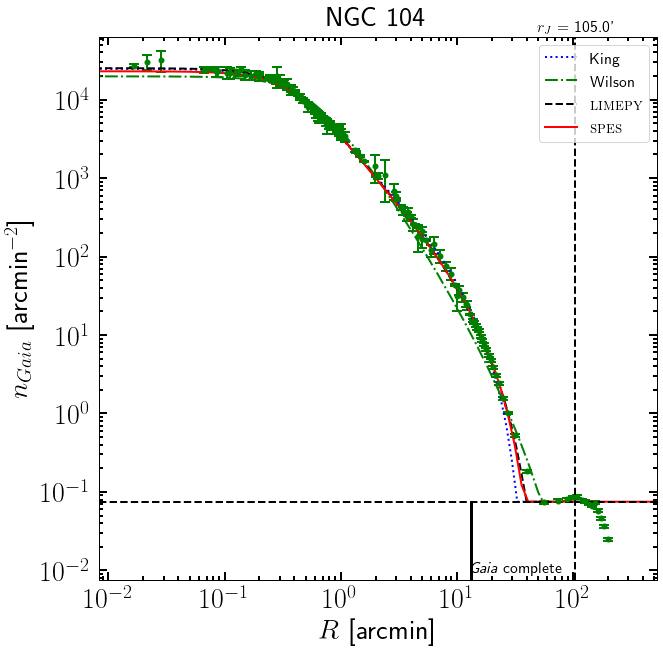


NGC 288 has 9137.2753 stars
NGC 288's distance from Sun is 8.90 kpc (Harris 1996, 2010 ed.)
NGC 288 has Jacobi radius 29.52' (Balbinot & Gieles 2018)



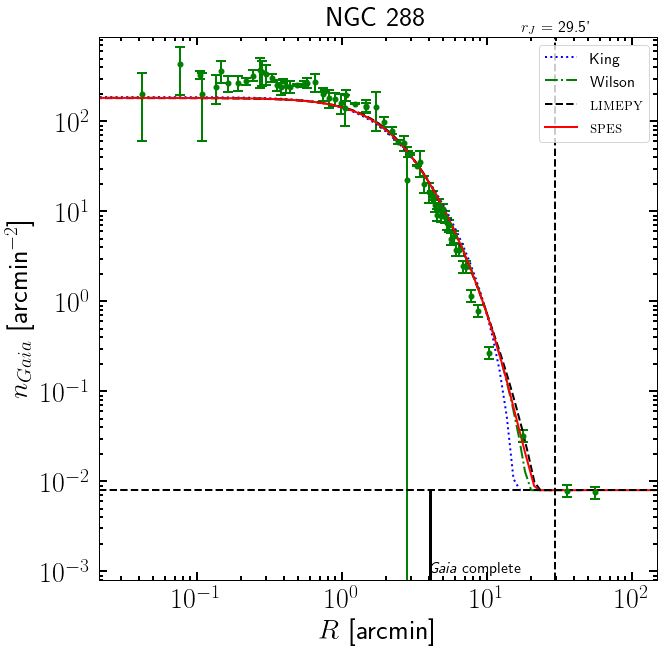


NGC 362 has 1016132.1511499999 stars
NGC 362's distance from Sun is 8.60 kpc (Harris 1996, 2010 ed.)
NGC 362 has Jacobi radius 44.79' (Balbinot & Gieles 2018)



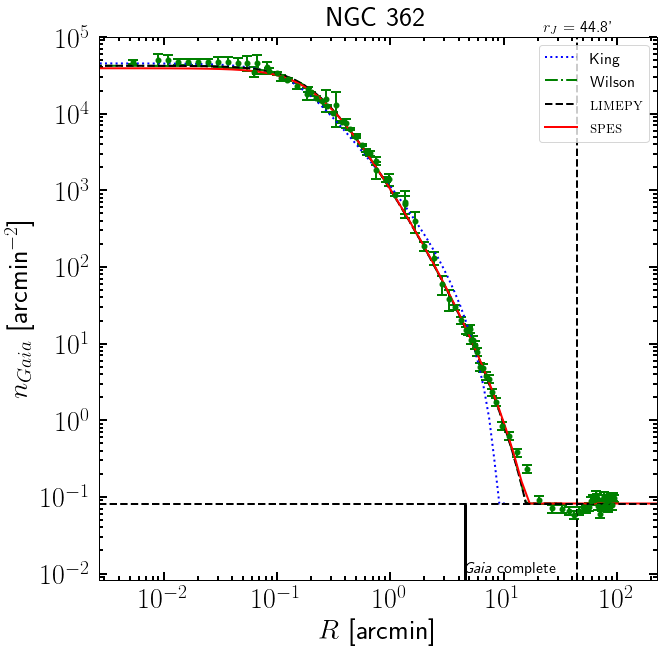


NGC 1261 has 70642.20797 stars
NGC 1261's distance from Sun is 16.30 kpc (Harris 1996, 2010 ed.)
NGC 1261 has Jacobi radius 30.87' (Balbinot & Gieles 2018)



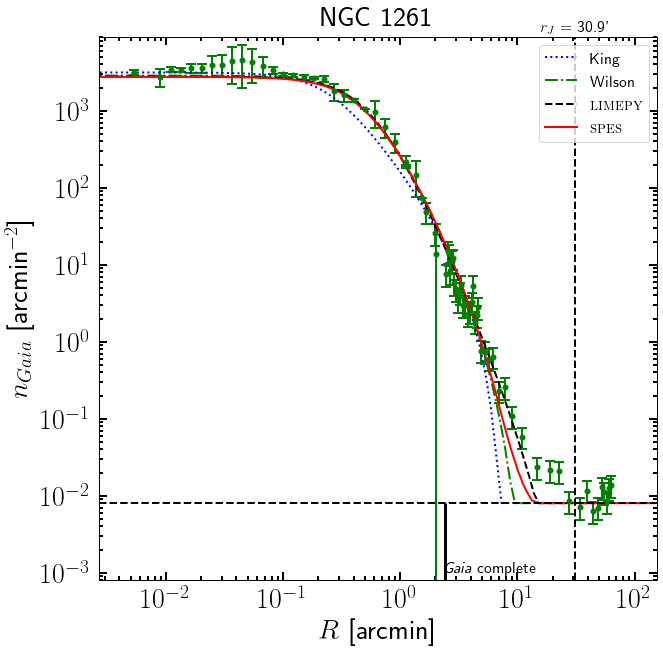


Pal 1 has 442.55353 stars
Pal 1's distance from Sun is 11.10 kpc (Harris 1996, 2010 ed.)
Pal 1 has Jacobi radius 7.00' (Balbinot & Gieles 2018)



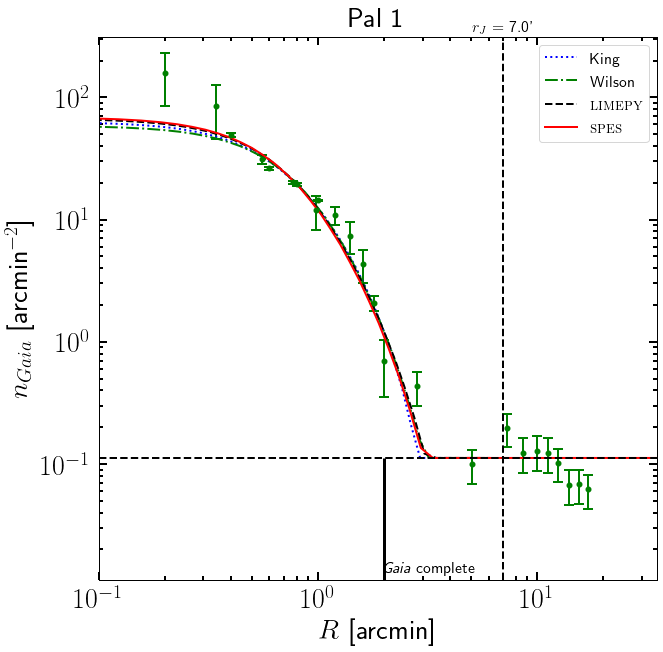


NGC 1851 has 1250633.04793 stars
NGC 1851's distance from Sun is 12.10 kpc (Harris 1996, 2010 ed.)
NGC 1851 has Jacobi radius 47.29' (Balbinot & Gieles 2018)



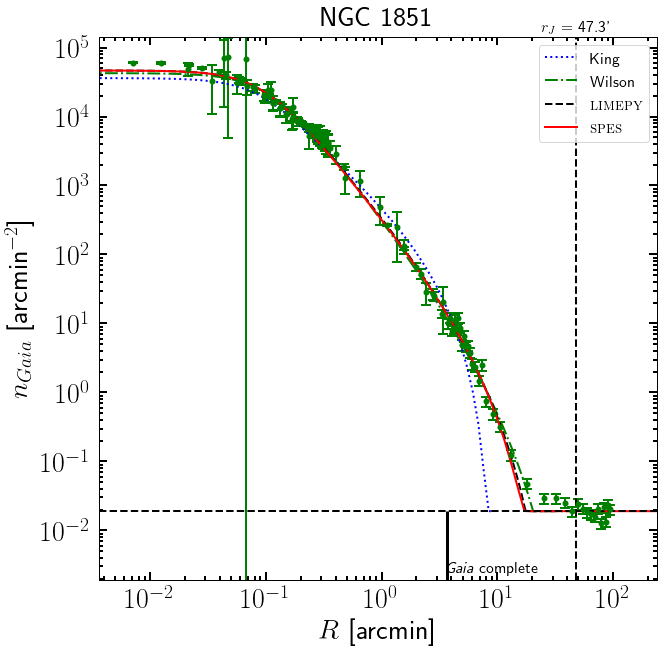


NGC 1904 has 44988.31277999999 stars
NGC 1904's distance from Sun is 12.90 kpc (Harris 1996, 2010 ed.)
NGC 1904 has Jacobi radius 40.98' (Balbinot & Gieles 2018)



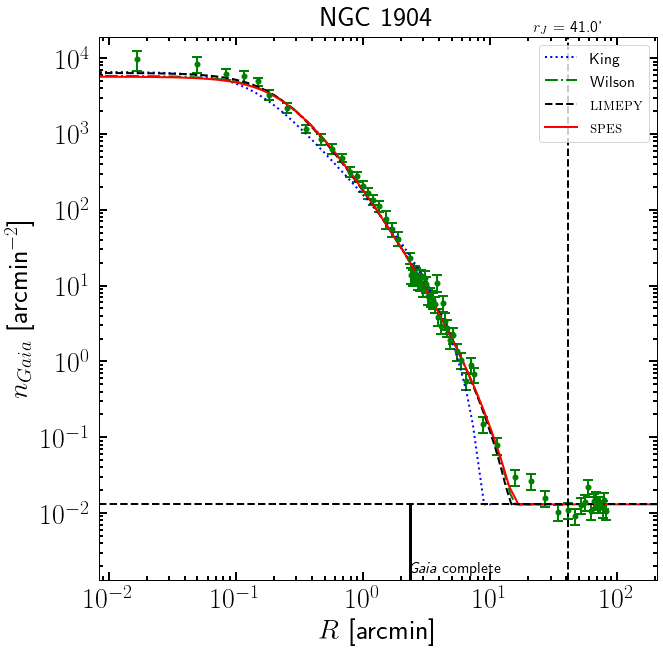


NGC 2298 has 24886.550319999995 stars
NGC 2298's distance from Sun is 10.80 kpc (Harris 1996, 2010 ed.)
NGC 2298 has Jacobi radius 25.87' (Balbinot & Gieles 2018)



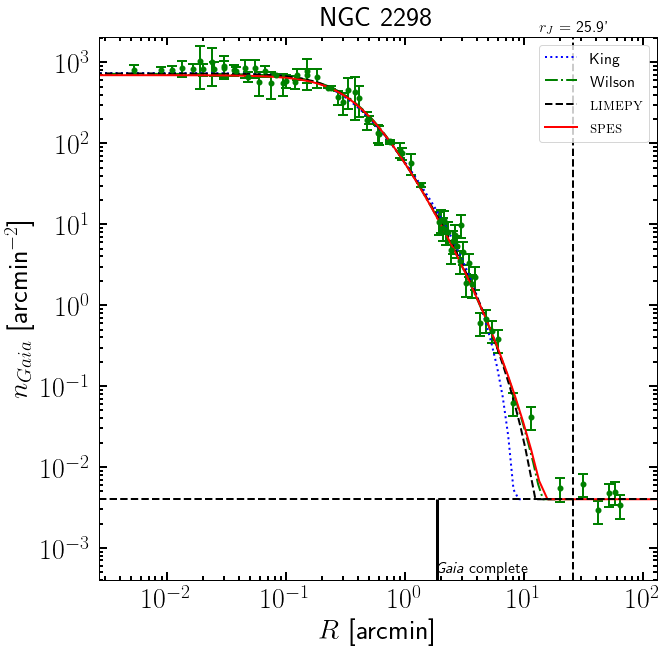


NGC 2419 has 1886.7072 stars
NGC 2419's distance from Sun is 82.60 kpc (Harris 1996, 2010 ed.)
NGC 2419 has Jacobi radius 29.93' (Balbinot & Gieles 2018)



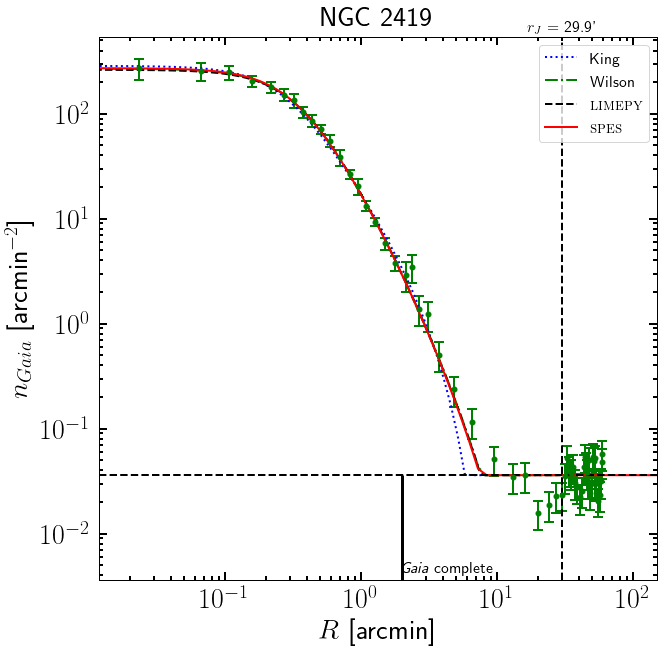


NGC 2808 has 1811172.30011 stars
NGC 2808's distance from Sun is 9.60 kpc (Harris 1996, 2010 ed.)
NGC 2808 has Jacobi radius 63.33' (Balbinot & Gieles 2018)



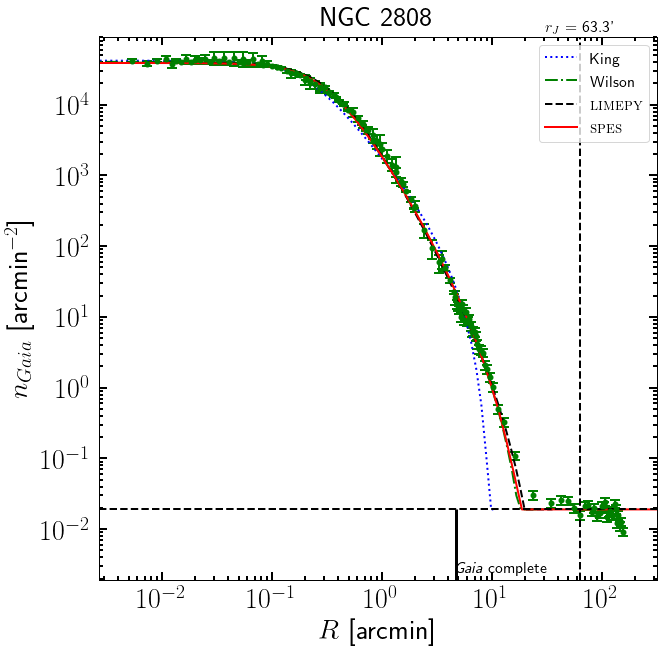


NGC 3201 has 66511.63572 stars
NGC 3201's distance from Sun is 4.90 kpc (Harris 1996, 2010 ed.)
NGC 3201 has Jacobi radius 58.55' (Balbinot & Gieles 2018)



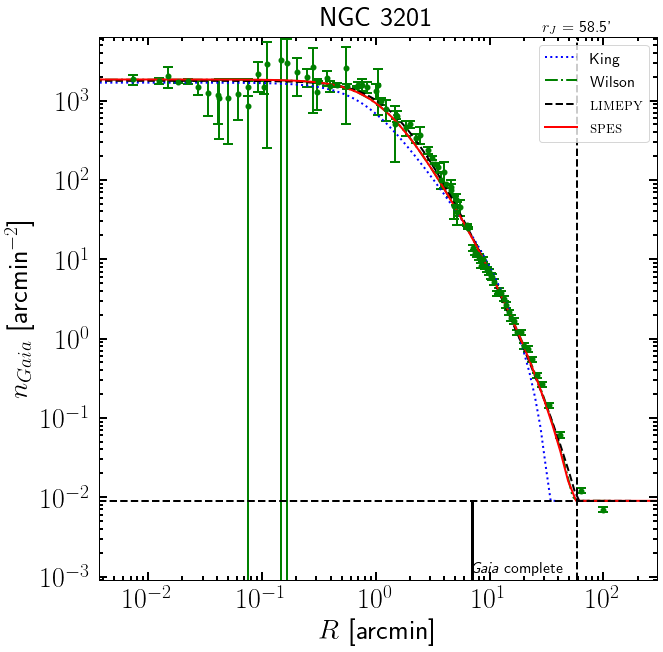


NGC 4147 has 94738.32981 stars
NGC 4147's distance from Sun is 19.30 kpc (Harris 1996, 2010 ed.)
NGC 4147 has Jacobi radius 17.09' (Balbinot & Gieles 2018)



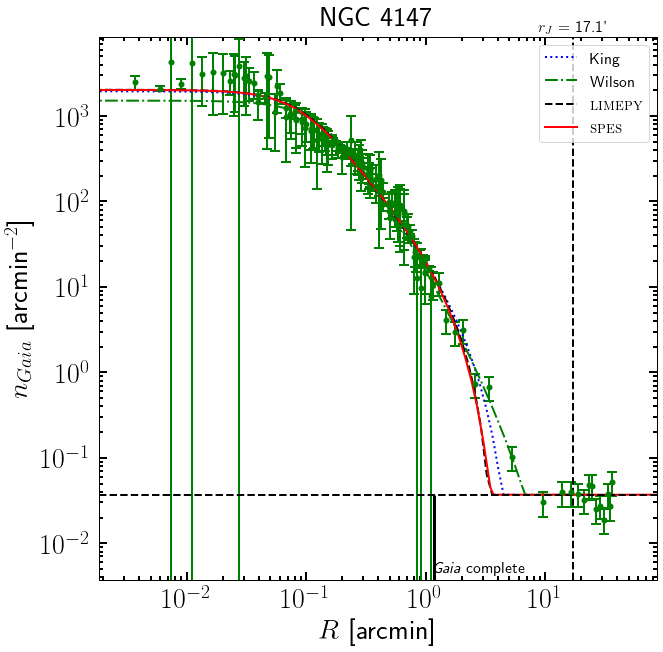


NGC 4590 has 85395.02007999999 stars
NGC 4590's distance from Sun is 10.30 kpc (Harris 1996, 2010 ed.)
NGC 4590 has Jacobi radius 29.55' (Balbinot & Gieles 2018)



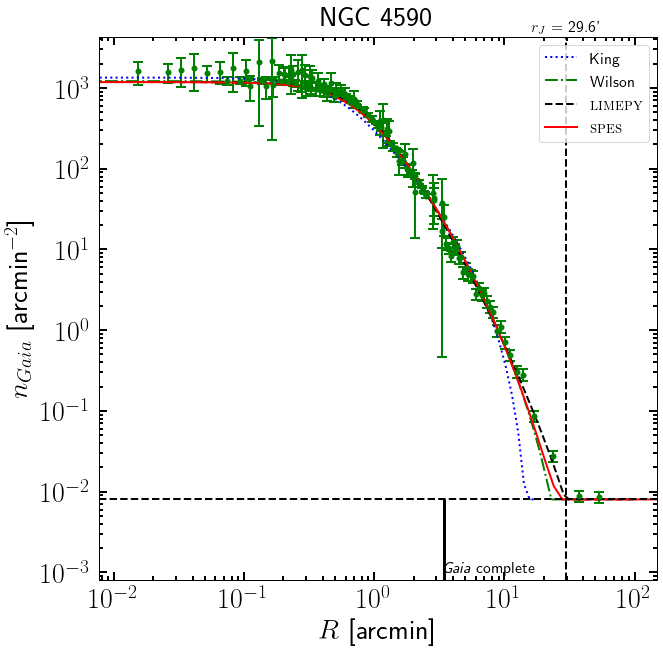


NGC 5024 has 7289.191609999999 stars
NGC 5024's distance from Sun is 17.90 kpc (Harris 1996, 2010 ed.)
NGC 5024 has Jacobi radius 38.22' (Balbinot & Gieles 2018)



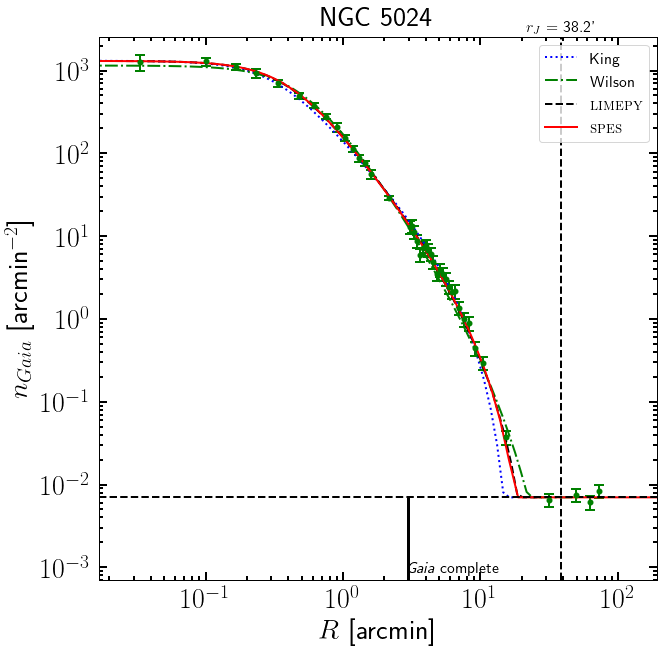


NGC 5053 has 1000.8348500000001 stars
NGC 5053's distance from Sun is 17.40 kpc (Harris 1996, 2010 ed.)
NGC 5053 has Jacobi radius 20.47' (Balbinot & Gieles 2018)



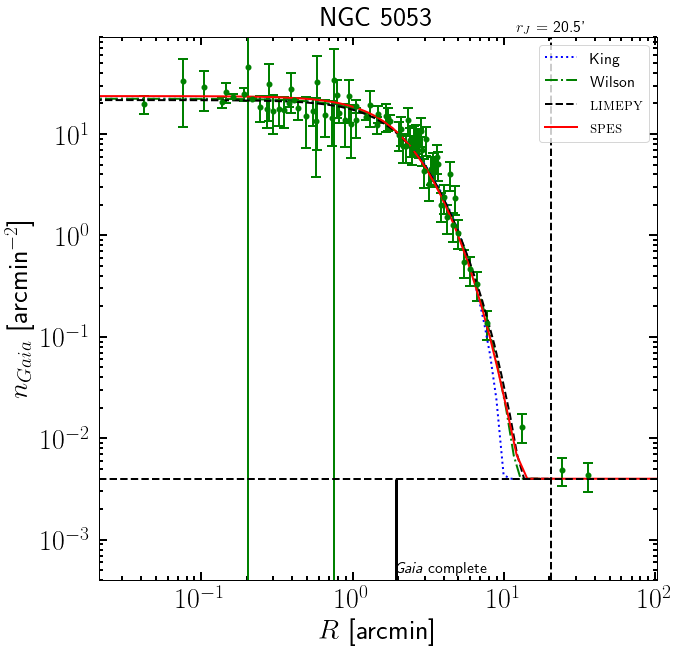


NGC 5139 has 46035.627739999996 stars
NGC 5139's distance from Sun is 5.20 kpc (Harris 1996, 2010 ed.)
NGC 5139 has Jacobi radius 106.87' (Balbinot & Gieles 2018)



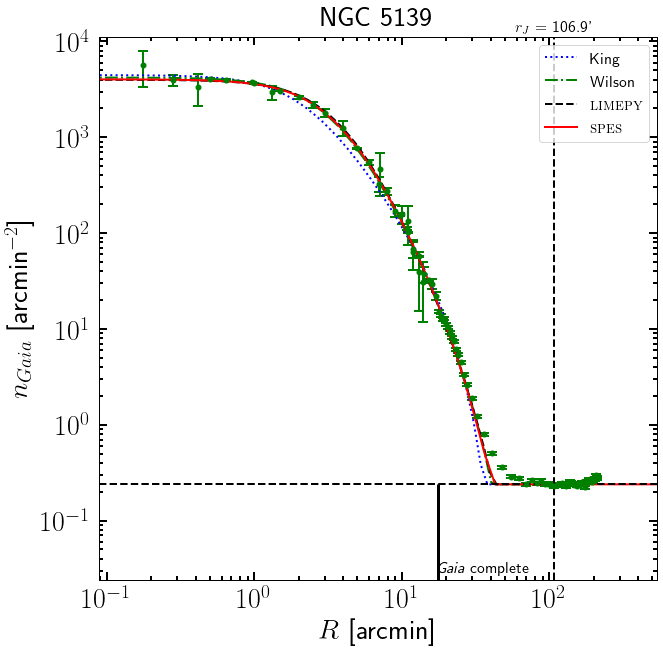


NGC 5272 has 36598.37461 stars
NGC 5272's distance from Sun is 10.20 kpc (Harris 1996, 2010 ed.)
NGC 5272 has Jacobi radius 53.46' (Balbinot & Gieles 2018)



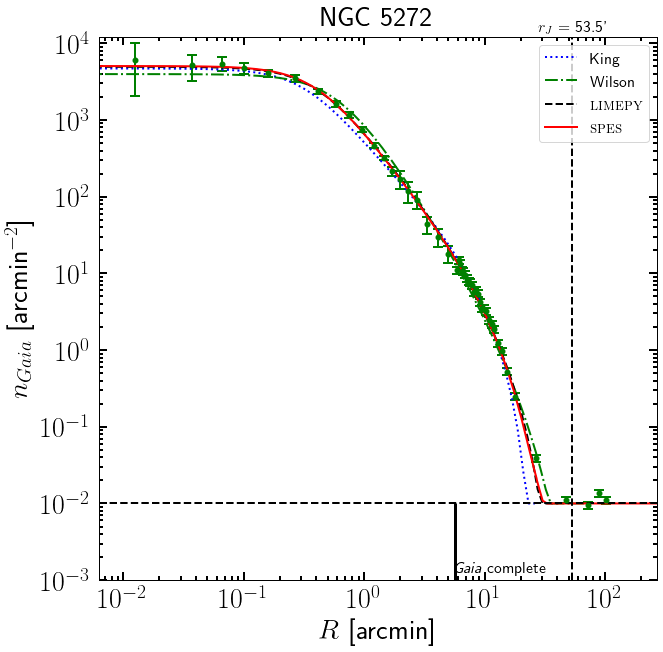


NGC 5286 has 97836.65403 stars
NGC 5286's distance from Sun is 11.70 kpc (Harris 1996, 2010 ed.)
NGC 5286 has Jacobi radius 35.73' (Balbinot & Gieles 2018)



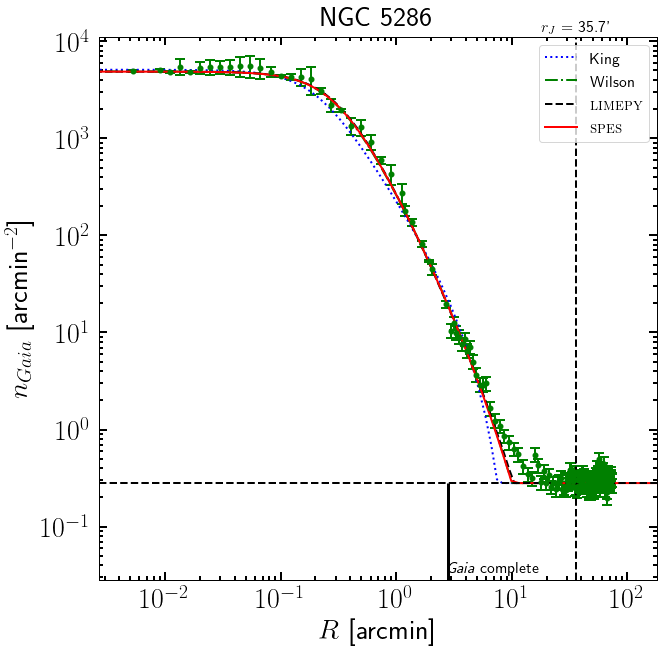


NGC 5466 has 446.36244 stars
NGC 5466's distance from Sun is 16.00 kpc (Harris 1996, 2010 ed.)
NGC 5466 has Jacobi radius 22.57' (Balbinot & Gieles 2018)



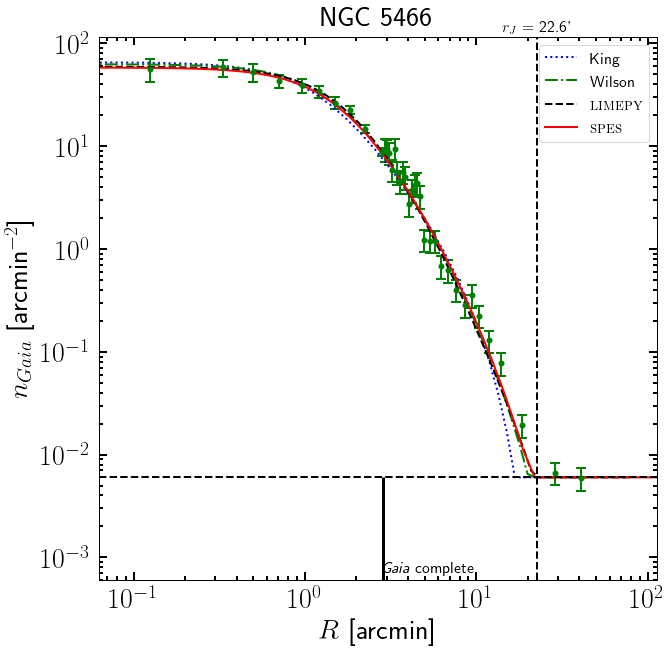


NGC 5634 has 47046.962660000005 stars
NGC 5634's distance from Sun is 25.20 kpc (Harris 1996, 2010 ed.)
NGC 5634 has Jacobi radius 21.62' (Balbinot & Gieles 2018)



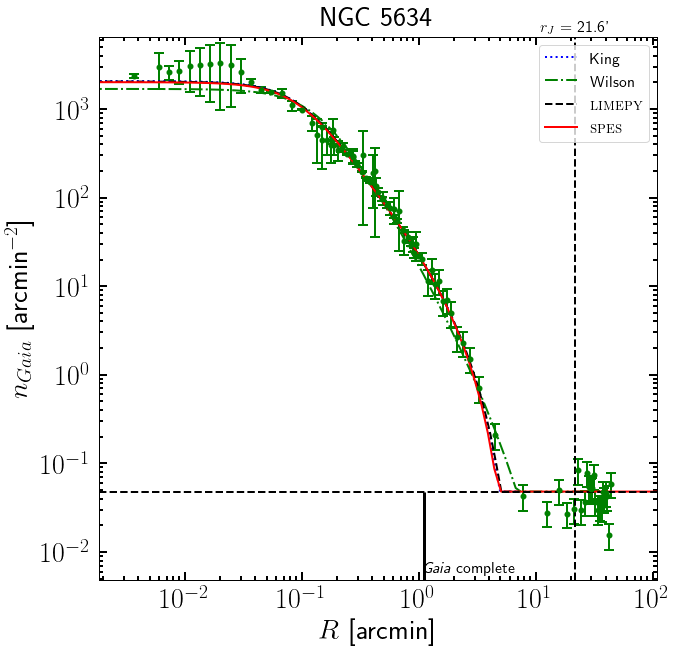


NGC 5694 has 72444.74214000002 stars
NGC 5694's distance from Sun is 35.00 kpc (Harris 1996, 2010 ed.)
NGC 5694 has Jacobi radius 20.01' (Balbinot & Gieles 2018)



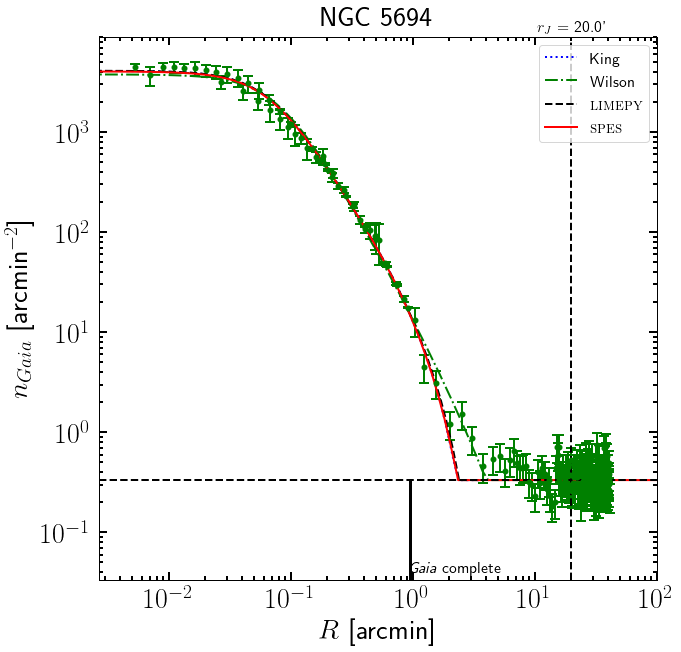


IC 4499 has 803.63792 stars
IC 4499's distance from Sun is 18.80 kpc (Harris 1996, 2010 ed.)
IC 4499 has Jacobi radius 20.64' (Balbinot & Gieles 2018)



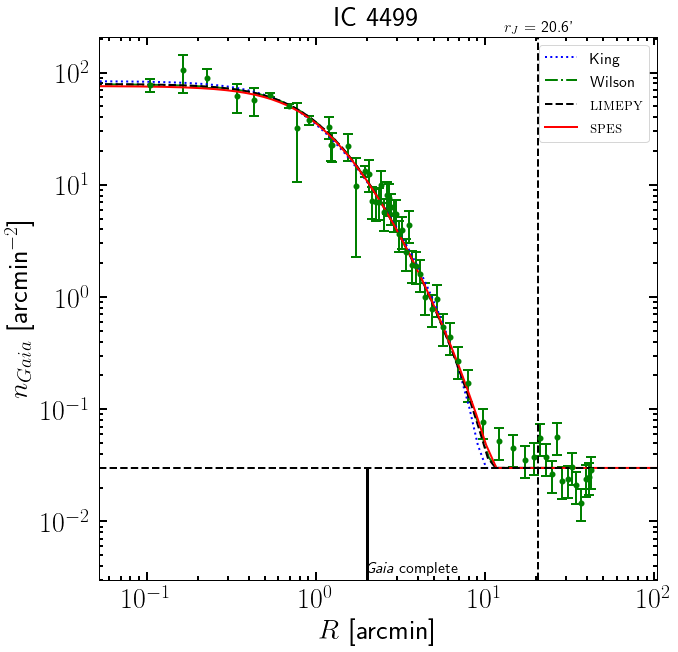


NGC 5824 has 288104.59579 stars
NGC 5824's distance from Sun is 32.10 kpc (Harris 1996, 2010 ed.)
NGC 5824 has Jacobi radius 27.63' (Balbinot & Gieles 2018)



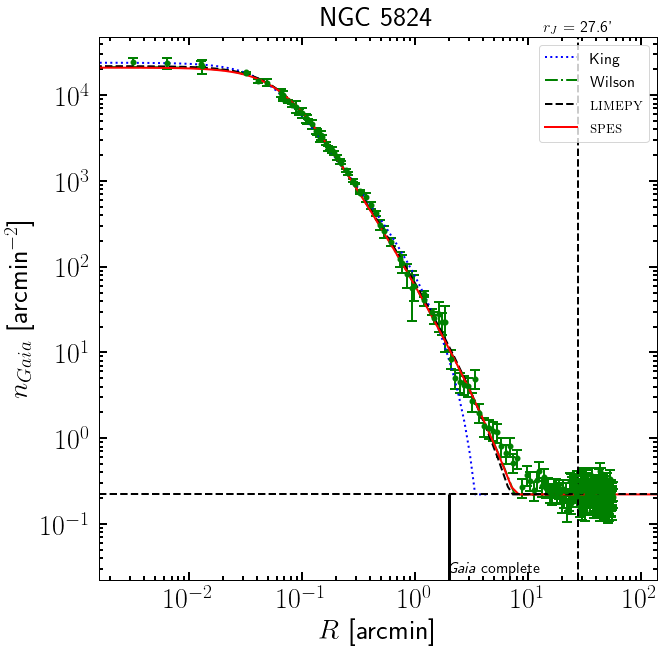


NGC 5897 has 9685.97391 stars
NGC 5897's distance from Sun is 12.50 kpc (Harris 1996, 2010 ed.)
NGC 5897 has Jacobi radius 17.32' (Balbinot & Gieles 2018)



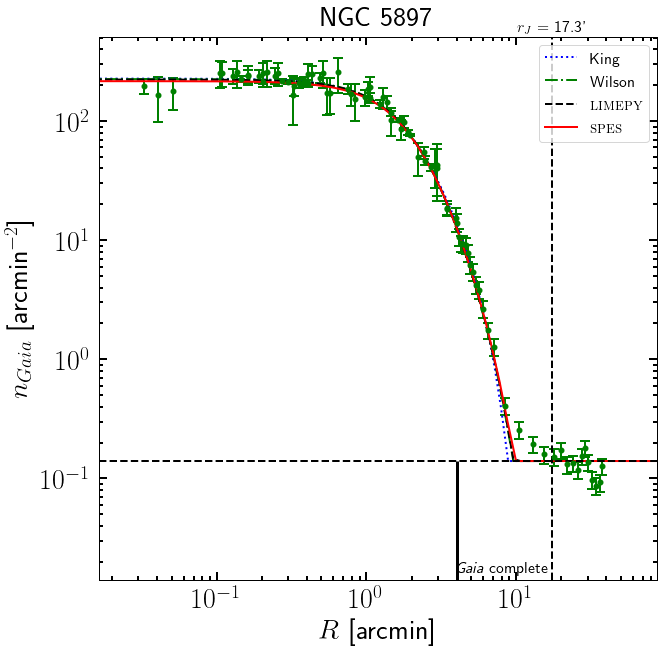


NGC 5904 has 71730.14221 stars
NGC 5904's distance from Sun is 7.50 kpc (Harris 1996, 2010 ed.)
NGC 5904 has Jacobi radius 46.07' (Balbinot & Gieles 2018)



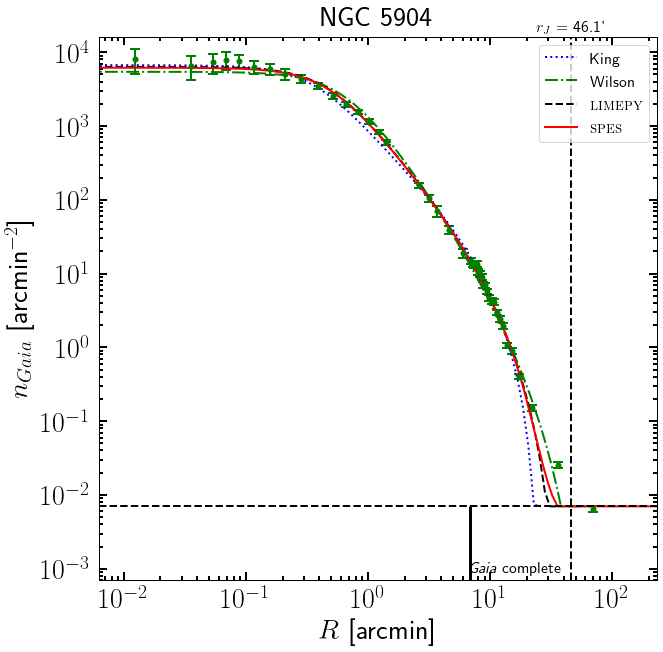


NGC 5986 has 24369.05673 stars
NGC 5986's distance from Sun is 10.40 kpc (Harris 1996, 2010 ed.)
NGC 5986 has Jacobi radius 21.83' (Balbinot & Gieles 2018)



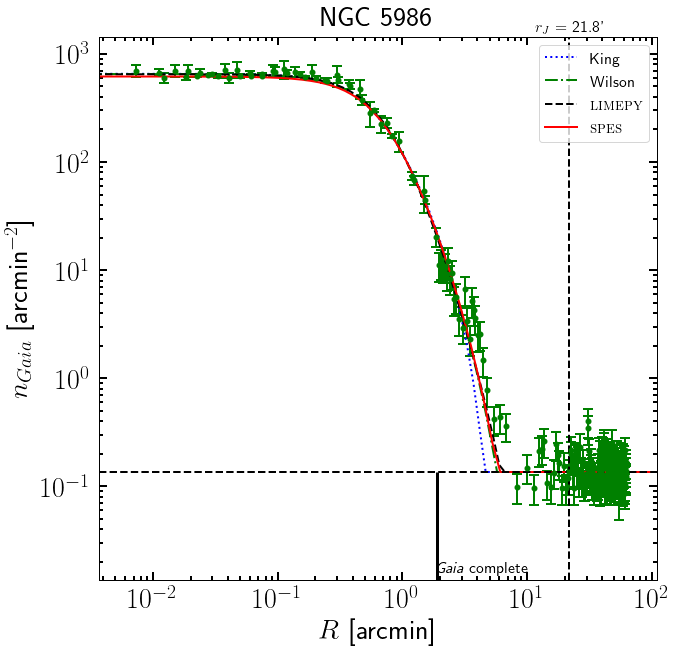


NGC 6093 has 1082295.05849 stars
NGC 6093's distance from Sun is 10.00 kpc (Harris 1996, 2010 ed.)
NGC 6093 has Jacobi radius 19.20' (Balbinot & Gieles 2018)



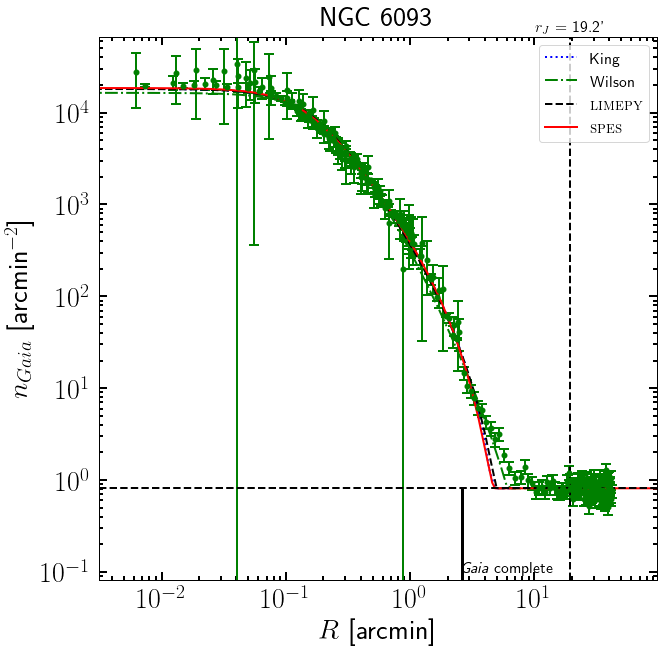


NGC 6121 has 1020.6485099999999 stars
NGC 6121's distance from Sun is 2.20 kpc (Harris 1996, 2010 ed.)
NGC 6121 has Jacobi radius 78.13' (Balbinot & Gieles 2018)



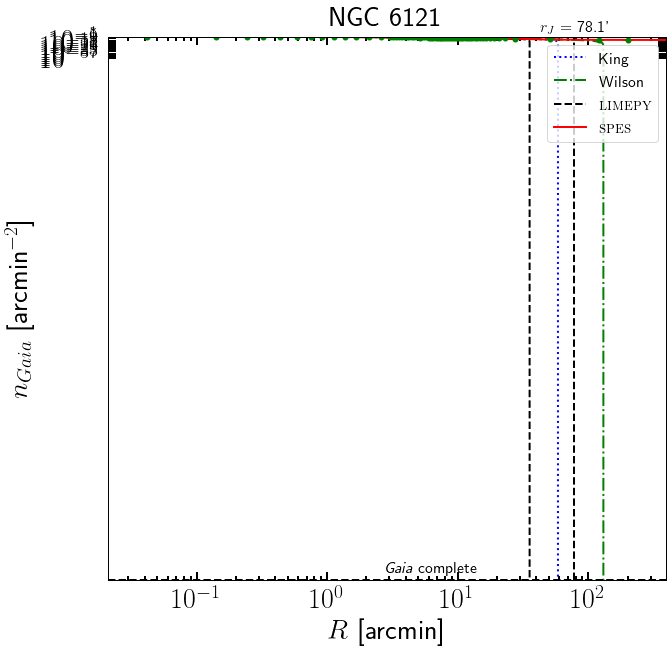


NGC 6101 has 4945.26529 stars
NGC 6101's distance from Sun is 15.40 kpc (Harris 1996, 2010 ed.)
NGC 6101 has Jacobi radius 17.42' (Balbinot & Gieles 2018)



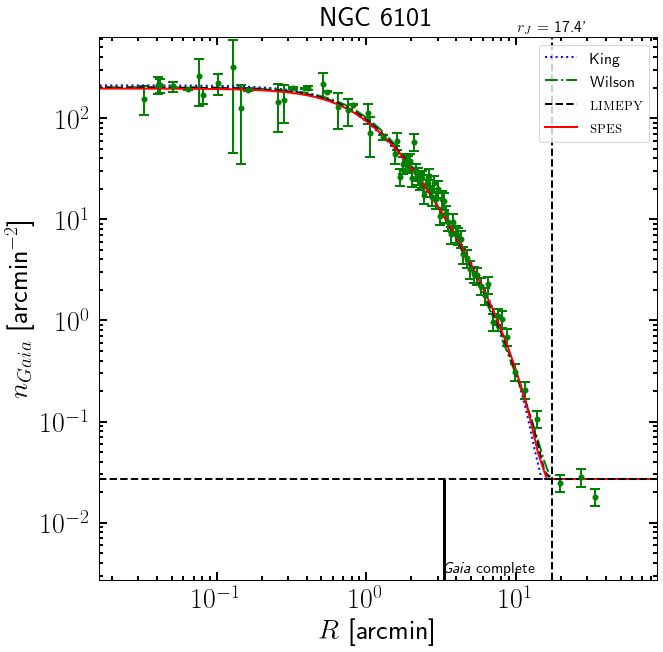


NGC 6144 has 2402.42264 stars
NGC 6144's distance from Sun is 8.90 kpc (Harris 1996, 2010 ed.)
NGC 6144 has Jacobi radius 10.31' (Balbinot & Gieles 2018)



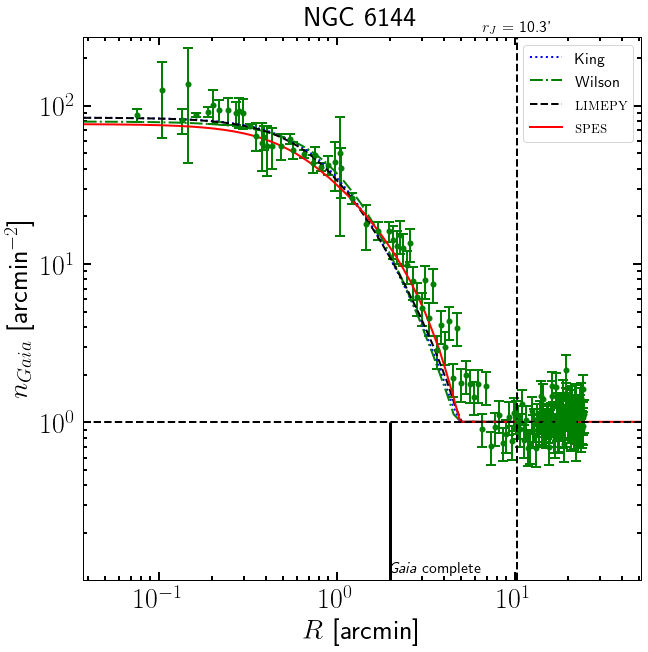


NGC 6139 has 7736.508449999999 stars
NGC 6139's distance from Sun is 10.10 kpc (Harris 1996, 2010 ed.)
NGC 6139 has Jacobi radius 19.38' (Balbinot & Gieles 2018)



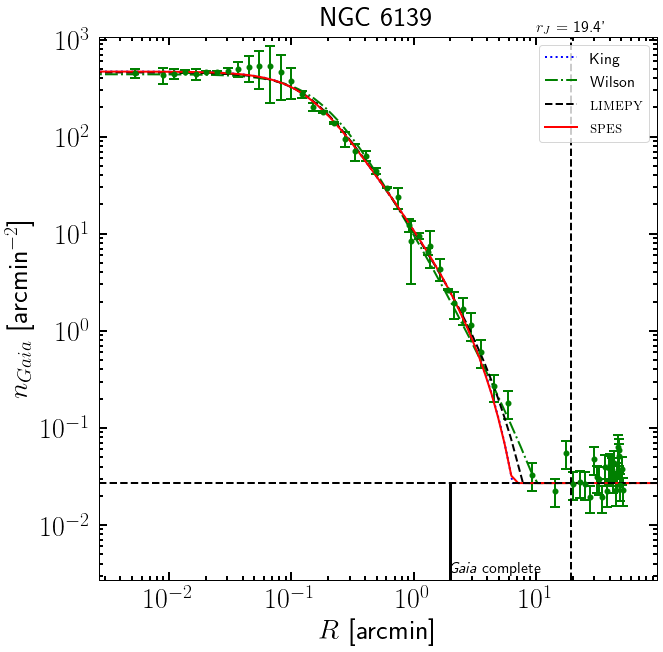


NGC 6171 has 28787.054949999998 stars
NGC 6171's distance from Sun is 6.40 kpc (Harris 1996, 2010 ed.)
NGC 6171 has Jacobi radius 19.60' (Balbinot & Gieles 2018)



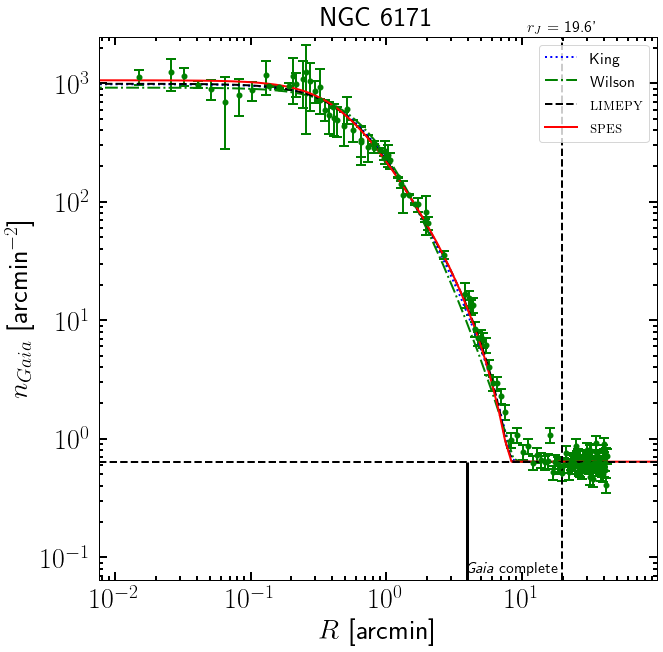


NGC 6205 has 163968.84824999998 stars
NGC 6205's distance from Sun is 7.10 kpc (Harris 1996, 2010 ed.)
NGC 6205 has Jacobi radius 54.83' (Balbinot & Gieles 2018)



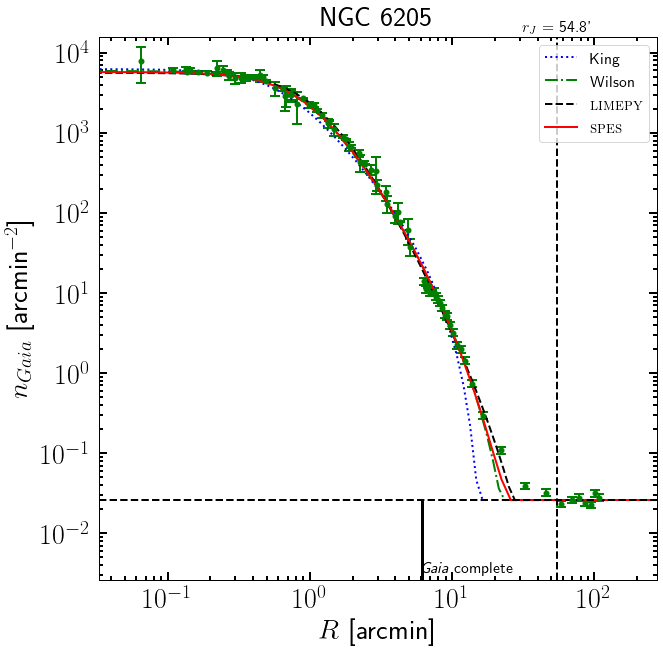


NGC 6229 has 10352.774220000001 stars
NGC 6229's distance from Sun is 30.50 kpc (Harris 1996, 2010 ed.)
NGC 6229 has Jacobi radius 25.09' (Balbinot & Gieles 2018)



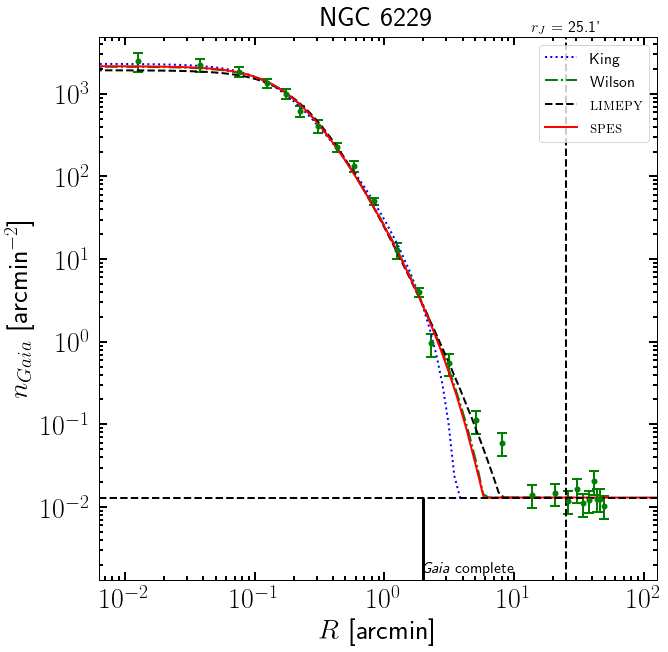


NGC 6218 has 78332.46675 stars
NGC 6218's distance from Sun is 4.80 kpc (Harris 1996, 2010 ed.)
NGC 6218 has Jacobi radius 34.91' (Balbinot & Gieles 2018)



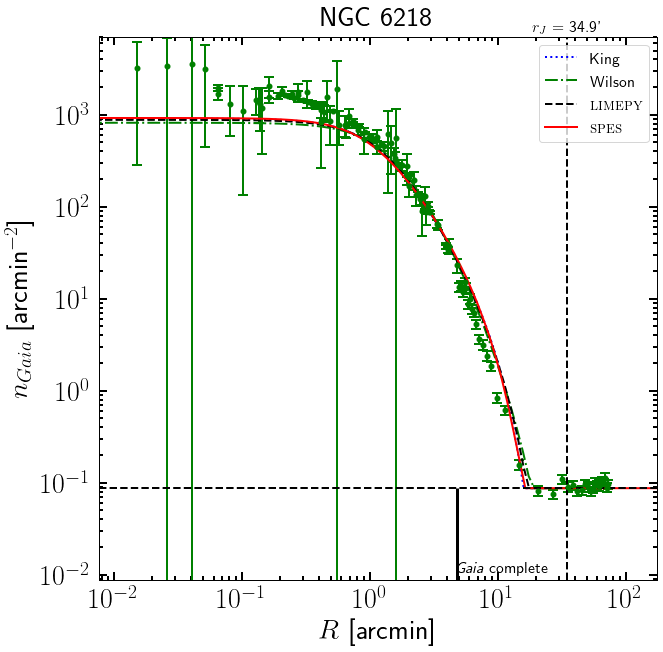


NGC 6235 has 9086.04081 stars
NGC 6235's distance from Sun is 11.50 kpc (Harris 1996, 2010 ed.)
NGC 6235 has Jacobi radius 8.60' (Balbinot & Gieles 2018)



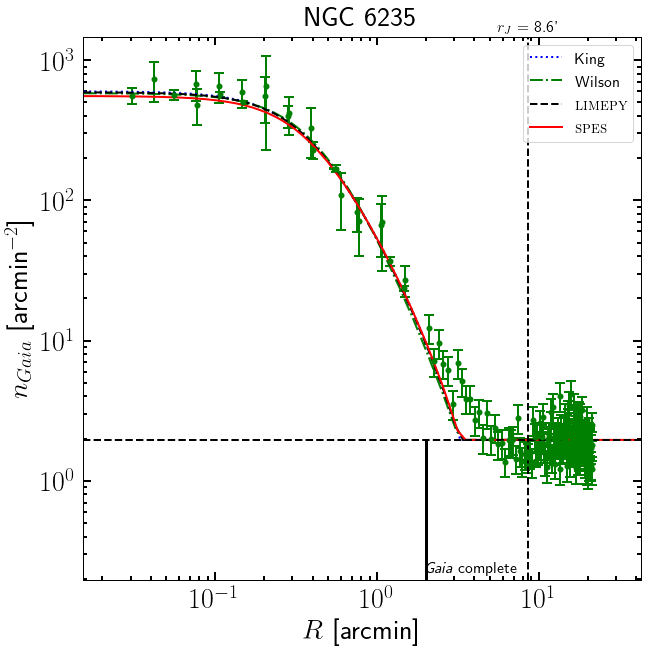


NGC 6254 has 9648.480220000001 stars
NGC 6254's distance from Sun is 4.40 kpc (Harris 1996, 2010 ed.)
NGC 6254 has Jacobi radius 41.38' (Balbinot & Gieles 2018)



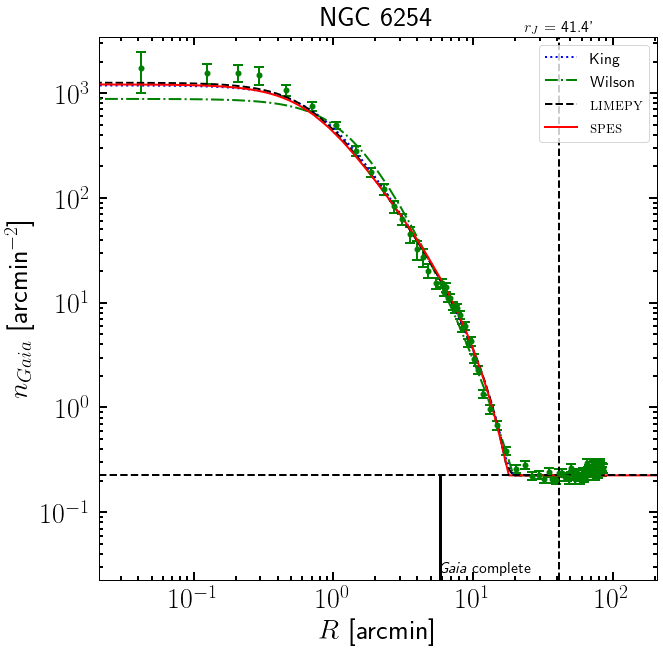


NGC 6266 has 317026.30493 stars
NGC 6266's distance from Sun is 6.80 kpc (Harris 1996, 2010 ed.)
NGC 6266 has Jacobi radius 25.85' (Balbinot & Gieles 2018)



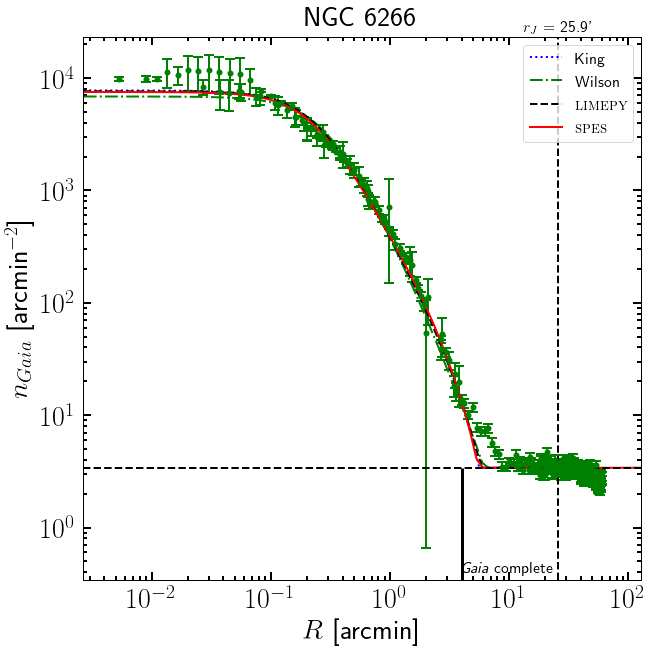


NGC 6273 has 140567.69142000002 stars
NGC 6273's distance from Sun is 8.80 kpc (Harris 1996, 2010 ed.)
NGC 6273 has Jacobi radius 16.49' (Balbinot & Gieles 2018)



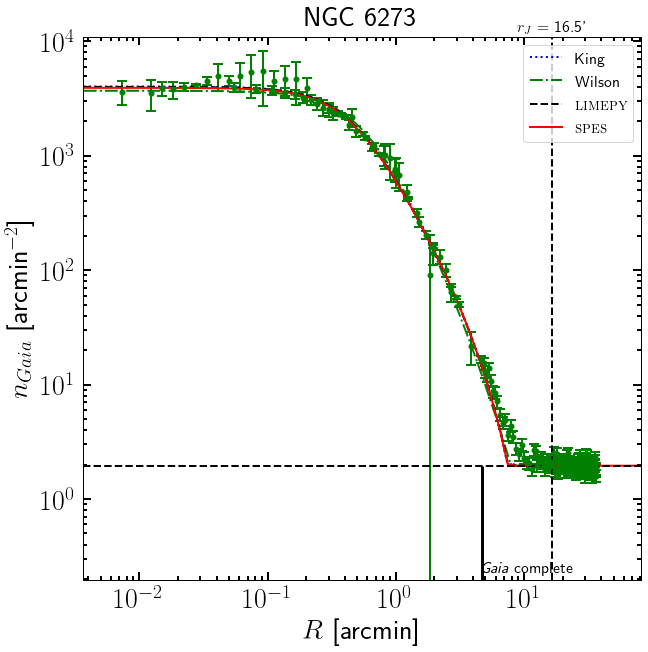


NGC 6284 has 5037.35504 stars
NGC 6284's distance from Sun is 15.30 kpc (Harris 1996, 2010 ed.)
NGC 6284 has Jacobi radius 18.51' (Balbinot & Gieles 2018)



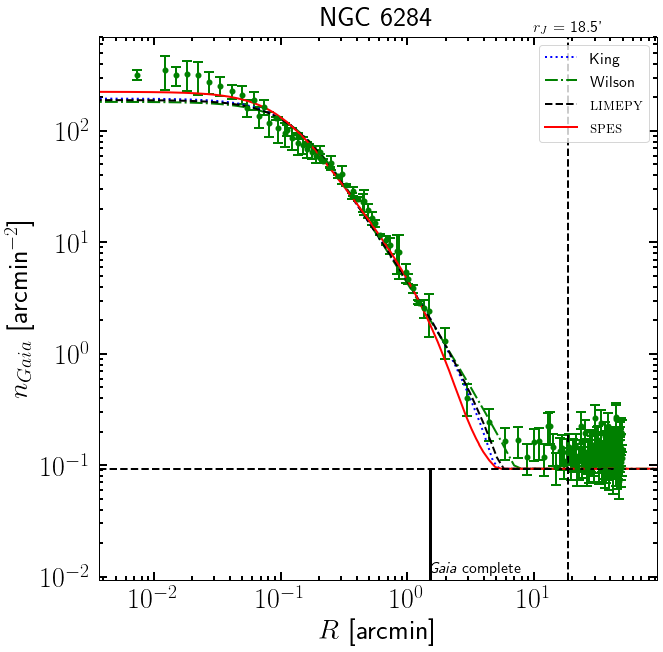


NGC 6293 has 98382.56351 stars
NGC 6293's distance from Sun is 9.50 kpc (Harris 1996, 2010 ed.)
NGC 6293 has Jacobi radius 10.13' (Balbinot & Gieles 2018)



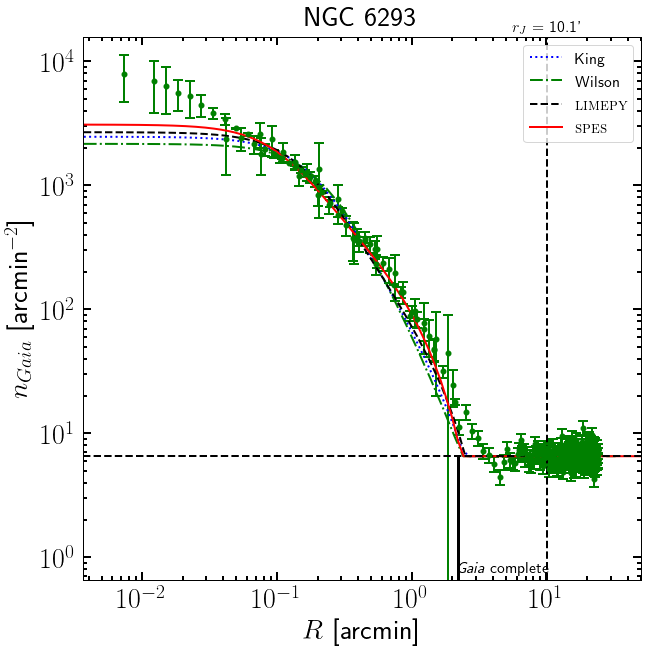


NGC 6341 has 60272.68674 stars
NGC 6341's distance from Sun is 8.30 kpc (Harris 1996, 2010 ed.)
NGC 6341 has Jacobi radius 42.87' (Balbinot & Gieles 2018)



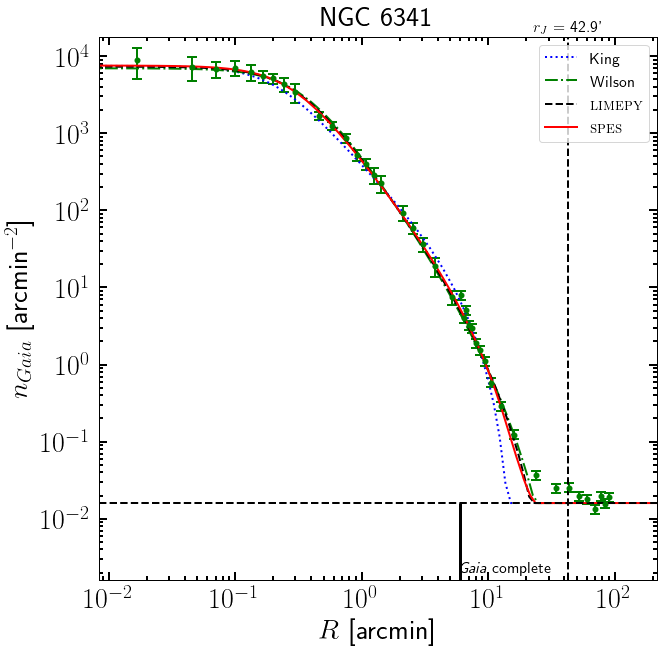


NGC 6325 has 8980.6822 stars
NGC 6325's distance from Sun is 7.80 kpc (Harris 1996, 2010 ed.)
NGC 6325 has Jacobi radius 6.90' (Balbinot & Gieles 2018)



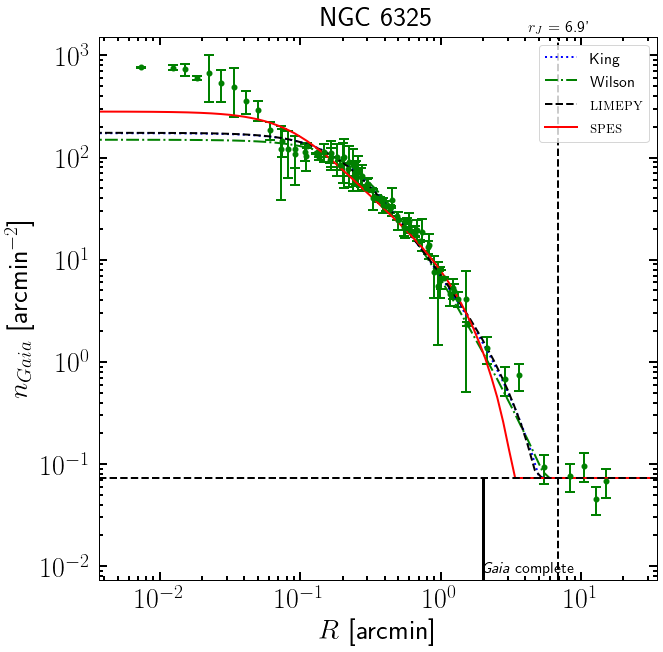


NGC 6333 has 497300.35696 stars
NGC 6333's distance from Sun is 7.90 kpc (Harris 1996, 2010 ed.)
NGC 6333 has Jacobi radius 13.41' (Balbinot & Gieles 2018)



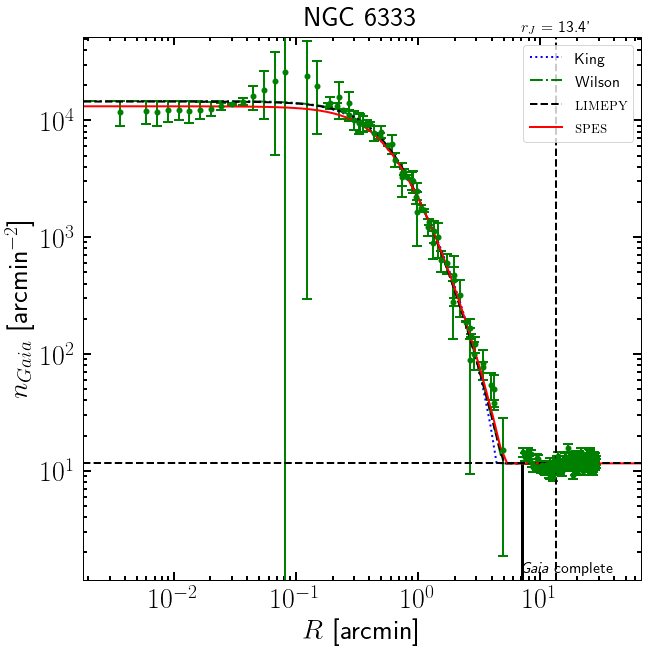


NGC 6352 has 24310.54536 stars
NGC 6352's distance from Sun is 5.60 kpc (Harris 1996, 2010 ed.)
NGC 6352 has Jacobi radius 17.43' (Balbinot & Gieles 2018)



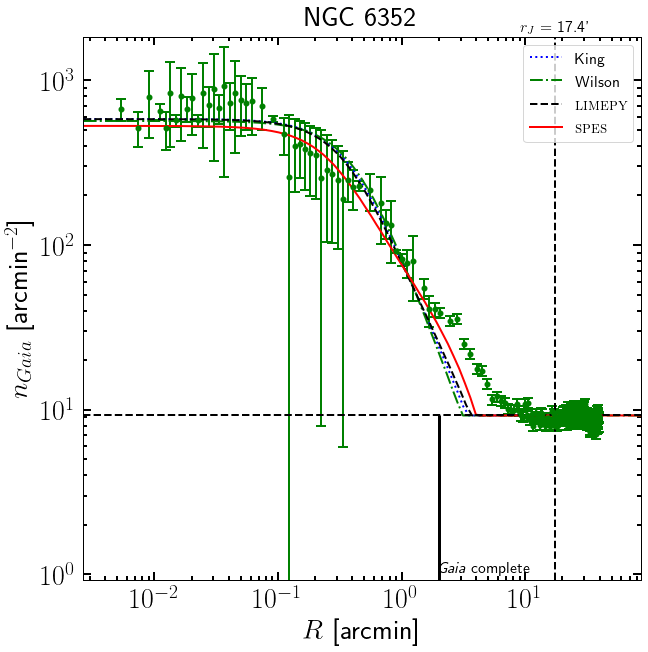


NGC 6366 has 3000.38314 stars
NGC 6366's distance from Sun is 3.50 kpc (Harris 1996, 2010 ed.)
NGC 6366 has Jacobi radius 27.24' (Balbinot & Gieles 2018)



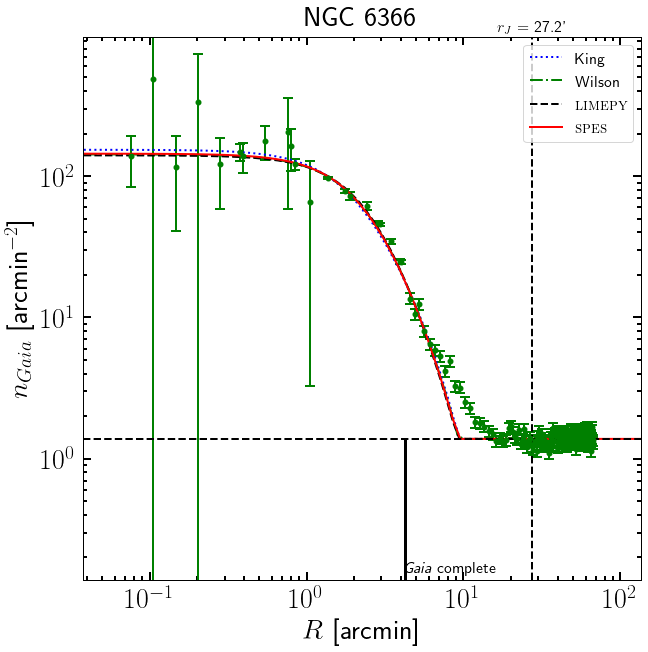


NGC 6362 has 16425.49334 stars
NGC 6362's distance from Sun is 7.60 kpc (Harris 1996, 2010 ed.)
NGC 6362 has Jacobi radius 20.25' (Balbinot & Gieles 2018)



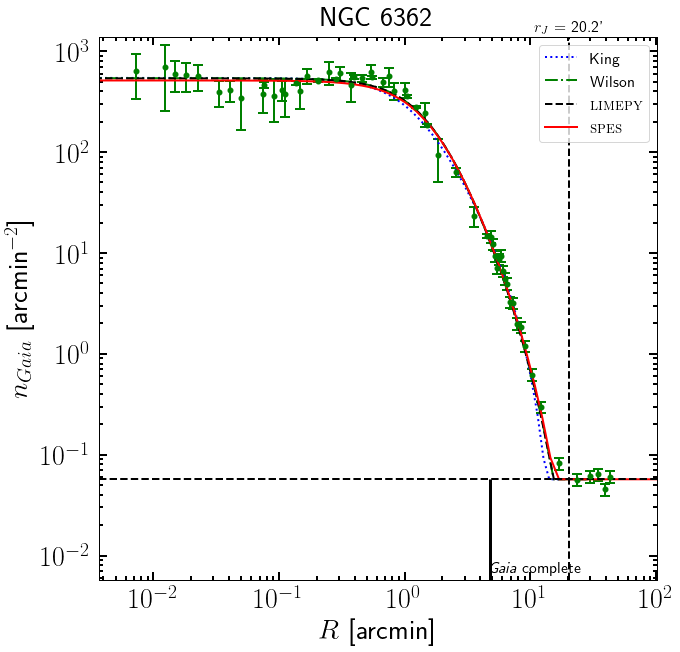


NGC 6388 has 157244.46296999996 stars
NGC 6388's distance from Sun is 9.90 kpc (Harris 1996, 2010 ed.)
NGC 6388 has Jacobi radius 24.64' (Balbinot & Gieles 2018)



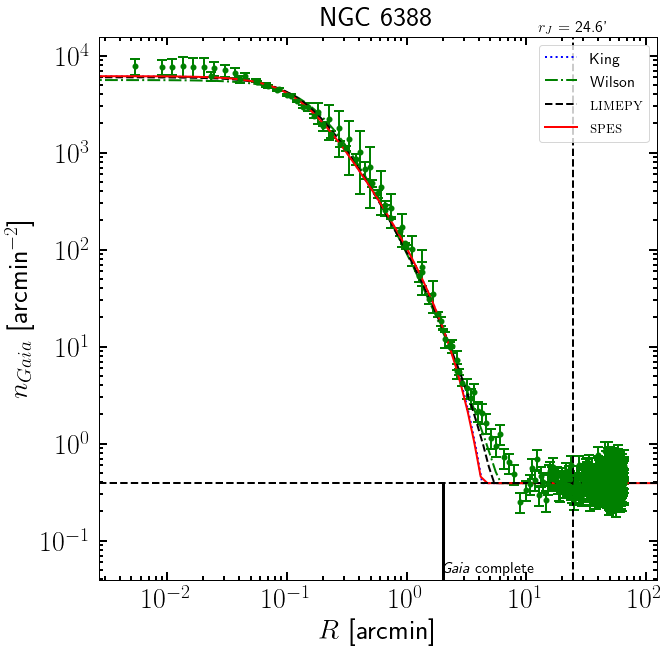


NGC 6402 has 43043.918249999995 stars
NGC 6402's distance from Sun is 9.30 kpc (Harris 1996, 2010 ed.)
NGC 6402 has Jacobi radius 29.49' (Balbinot & Gieles 2018)



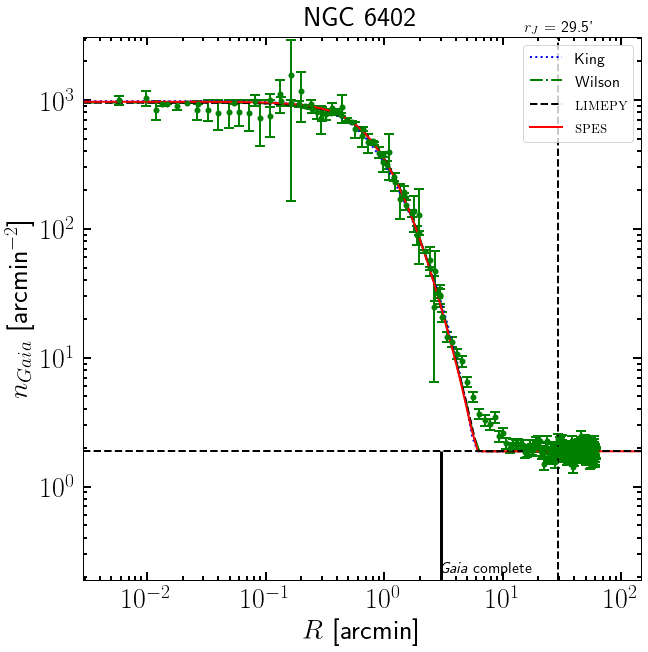


NGC 6397 has 104426.35108000001 stars
NGC 6397's distance from Sun is 2.30 kpc (Harris 1996, 2010 ed.)
NGC 6397 has Jacobi radius 68.69' (Balbinot & Gieles 2018)



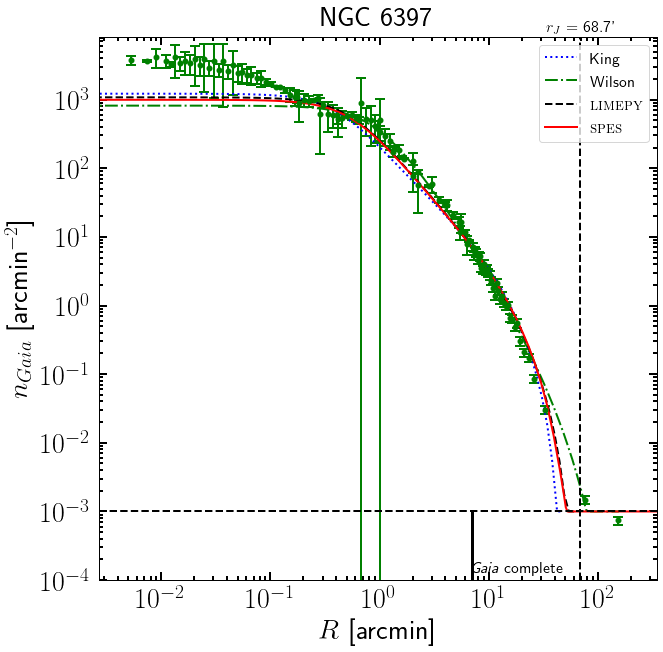


NGC 6426 has 4791.0813100000005 stars
NGC 6426's distance from Sun is 20.60 kpc (Harris 1996, 2010 ed.)
NGC 6426 has Jacobi radius 14.81' (Balbinot & Gieles 2018)



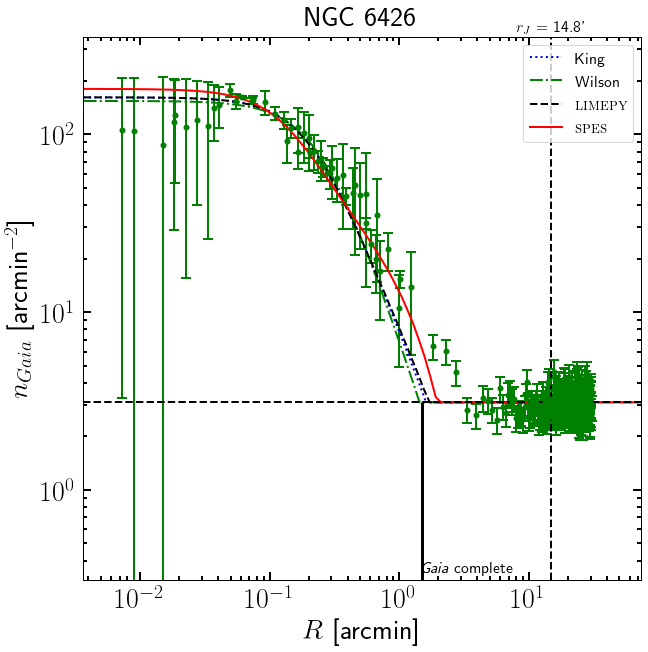


NGC 6496 has 2690.7153600000006 stars
NGC 6496's distance from Sun is 11.30 kpc (Harris 1996, 2010 ed.)
NGC 6496 has Jacobi radius 12.62' (Balbinot & Gieles 2018)



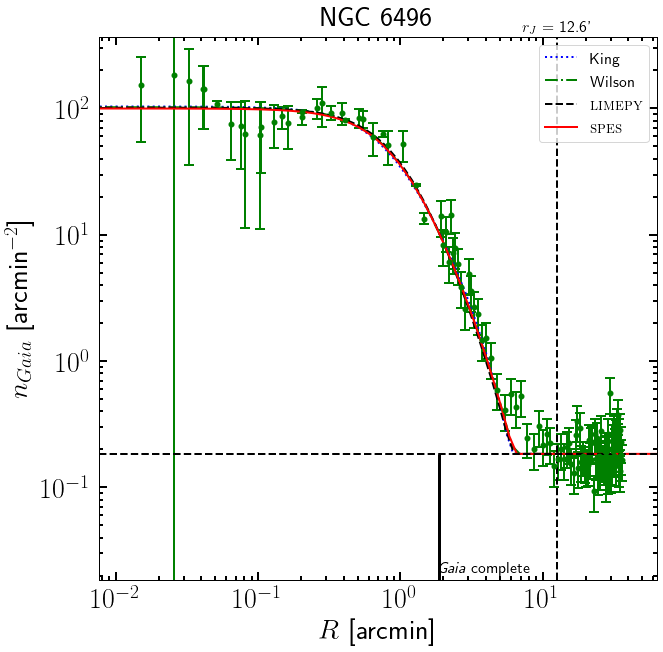


NGC 6539 has 14293.626359999998 stars
NGC 6539's distance from Sun is 7.80 kpc (Harris 1996, 2010 ed.)
NGC 6539 has Jacobi radius 22.37' (Balbinot & Gieles 2018)



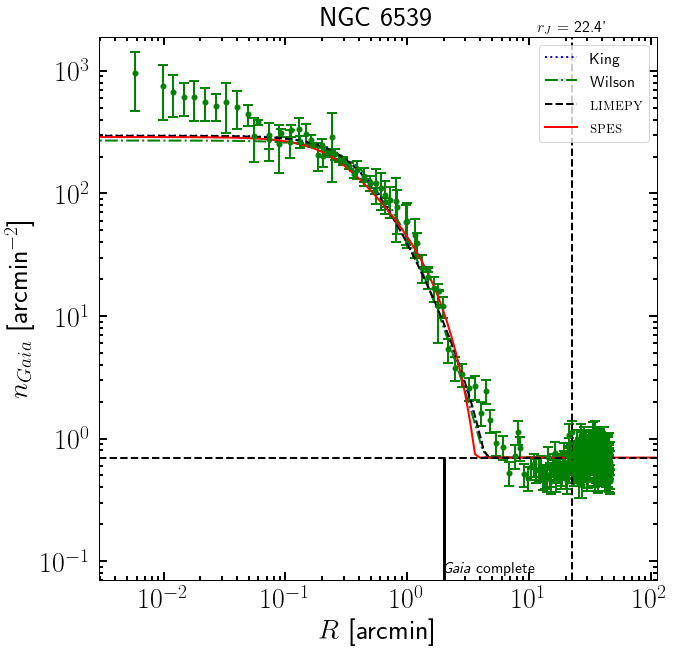


NGC 6541 has 174009.86726 stars
NGC 6541's distance from Sun is 7.50 kpc (Harris 1996, 2010 ed.)
NGC 6541 has Jacobi radius 20.12' (Balbinot & Gieles 2018)



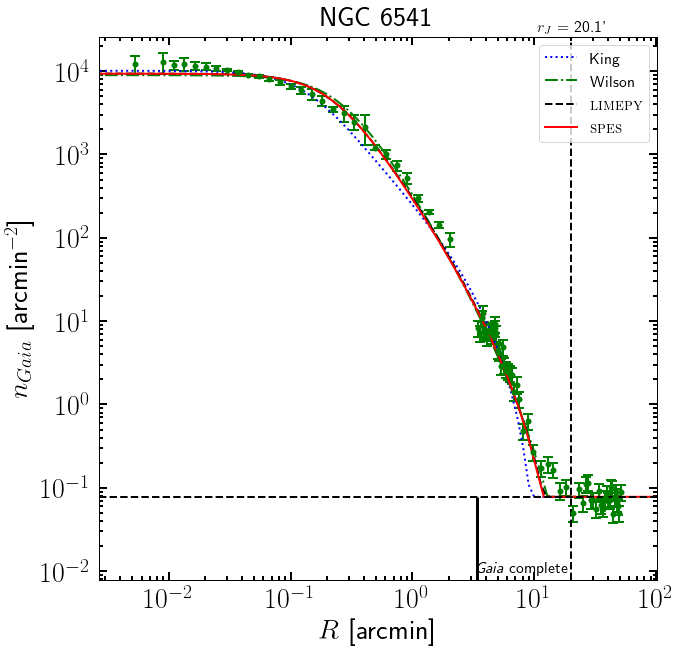


IC 1276 has 15013.85194 stars
IC 1276's distance from Sun is 5.40 kpc (Harris 1996, 2010 ed.)
IC 1276 has Jacobi radius 19.97' (Balbinot & Gieles 2018)



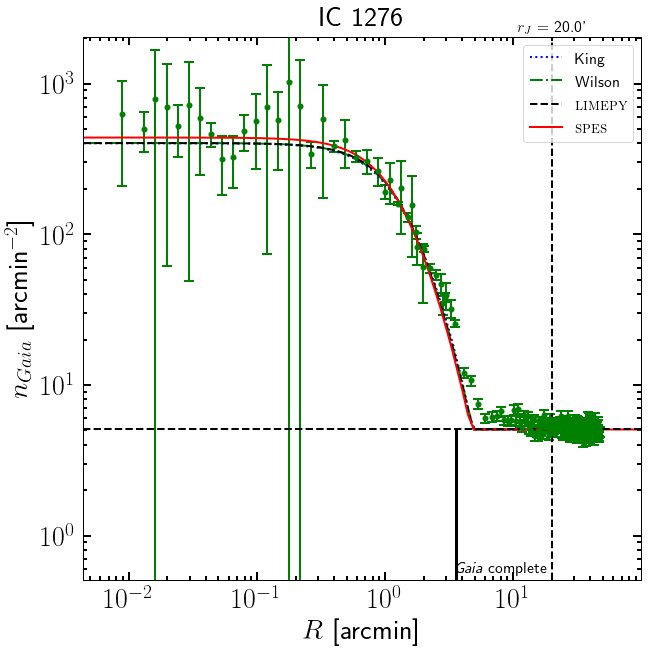


NGC 6569 has 9279.54098 stars
NGC 6569's distance from Sun is 10.90 kpc (Harris 1996, 2010 ed.)
NGC 6569 has Jacobi radius 14.79' (Balbinot & Gieles 2018)



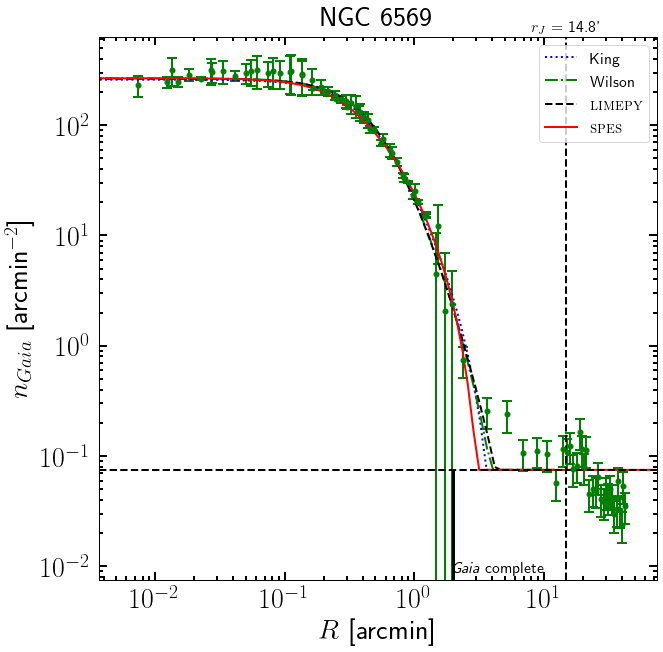


NGC 6584 has 50226.7825 stars
NGC 6584's distance from Sun is 13.50 kpc (Harris 1996, 2010 ed.)
NGC 6584 has Jacobi radius 17.69' (Balbinot & Gieles 2018)



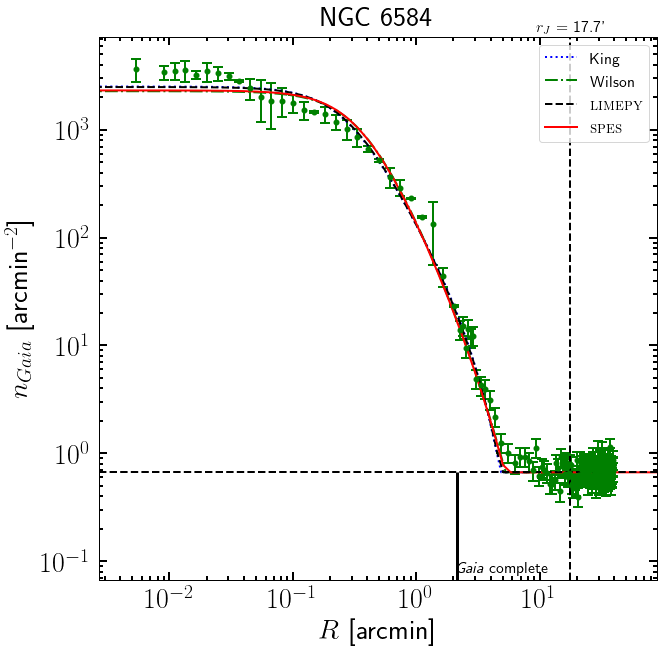


NGC 6624 has 206809.36364 stars
NGC 6624's distance from Sun is 7.90 kpc (Harris 1996, 2010 ed.)
NGC 6624 has Jacobi radius 8.56' (Balbinot & Gieles 2018)



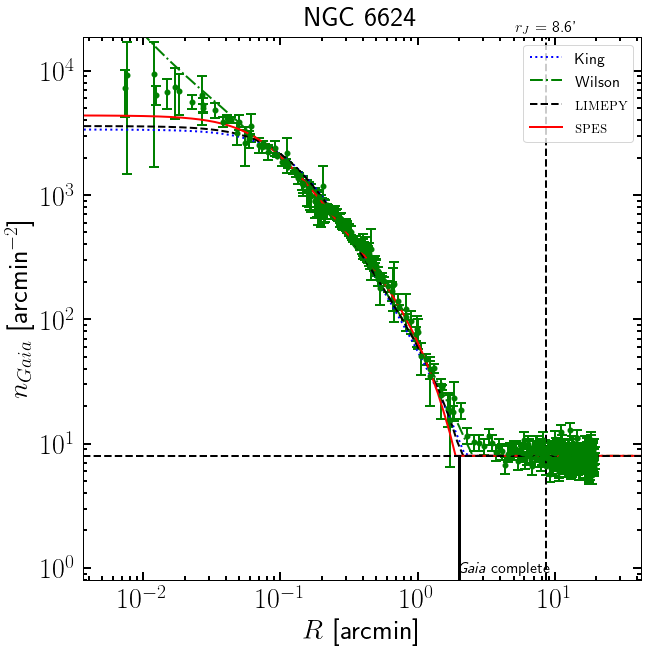


NGC 6626 has 62442.91935999999 stars
NGC 6626's distance from Sun is 5.50 kpc (Harris 1996, 2010 ed.)
NGC 6626 has Jacobi radius 29.00' (Balbinot & Gieles 2018)



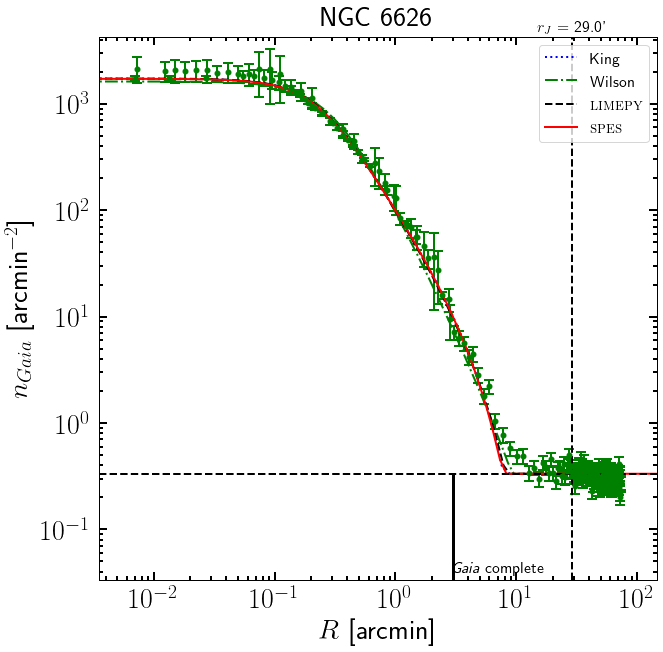


NGC 6637 has 39707.69106 stars
NGC 6637's distance from Sun is 8.80 kpc (Harris 1996, 2010 ed.)
NGC 6637 has Jacobi radius 9.74' (Balbinot & Gieles 2018)



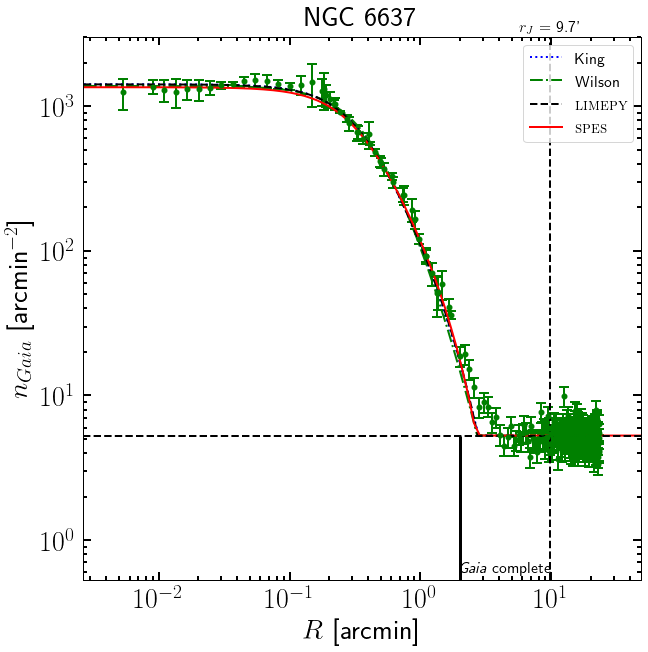


NGC 6652 has 167297.57971 stars
NGC 6652's distance from Sun is 10.00 kpc (Harris 1996, 2010 ed.)
NGC 6652 has Jacobi radius 9.04' (Balbinot & Gieles 2018)



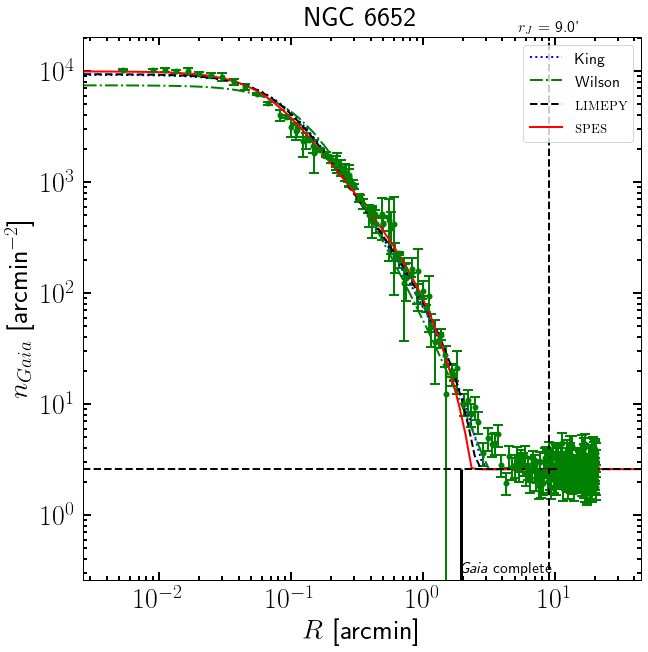


NGC 6656 has 37195.70524 stars
NGC 6656's distance from Sun is 3.20 kpc (Harris 1996, 2010 ed.)
NGC 6656 has Jacobi radius 84.83' (Balbinot & Gieles 2018)



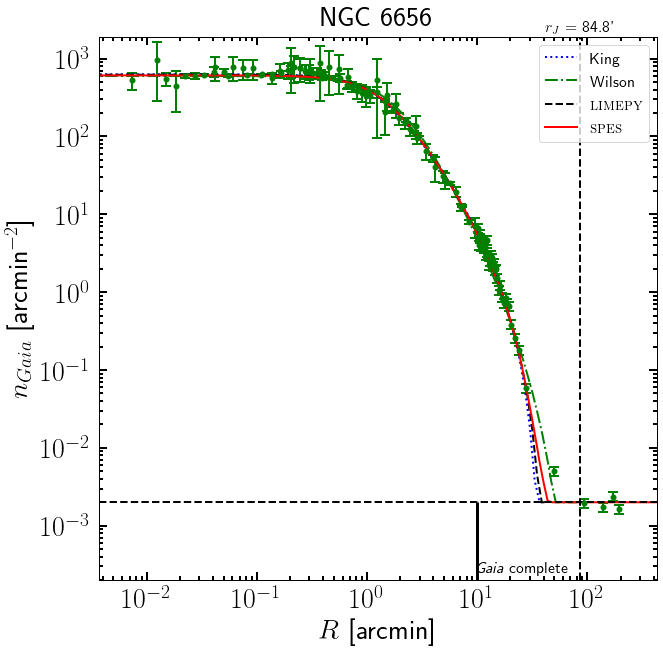


Pal 8 has 4230.03009 stars
Pal 8's distance from Sun is 12.80 kpc (Harris 1996, 2010 ed.)
Pal 8 has Jacobi radius 6.96' (Balbinot & Gieles 2018)



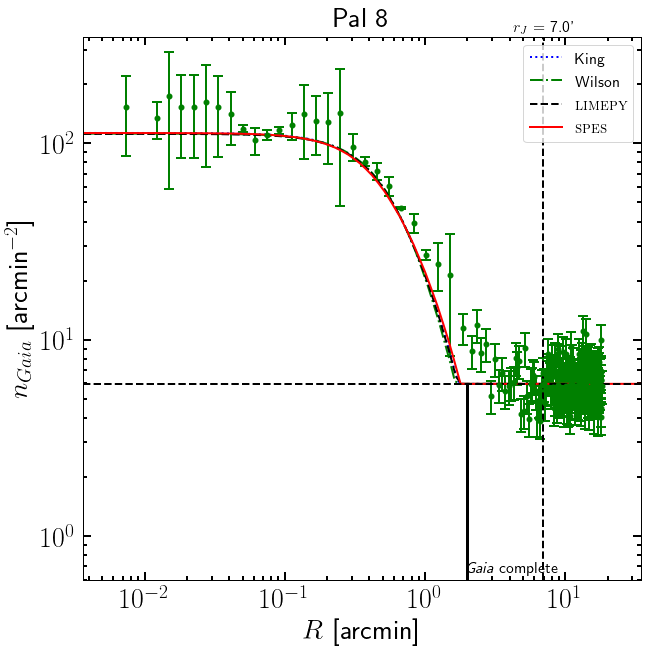


NGC 6681 has 279953.75552999997 stars
NGC 6681's distance from Sun is 9.00 kpc (Harris 1996, 2010 ed.)
NGC 6681 has Jacobi radius 8.49' (Balbinot & Gieles 2018)



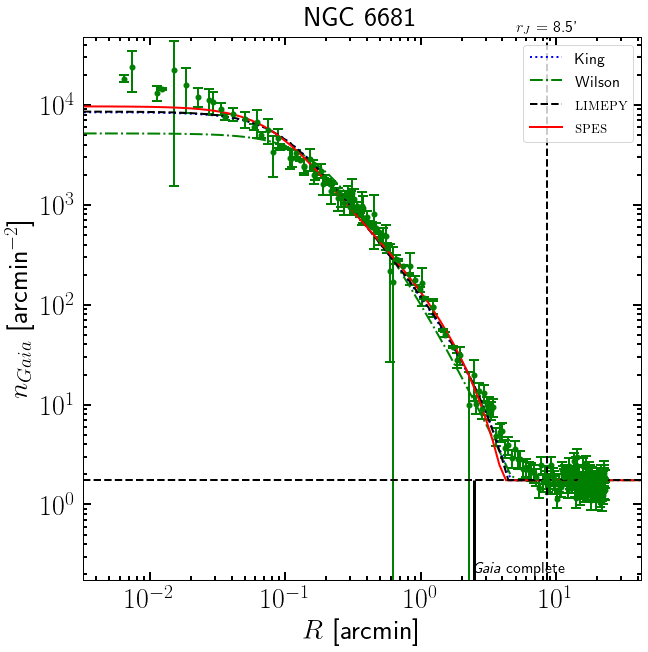


NGC 6715 has 396748.00296 stars
NGC 6715's distance from Sun is 26.50 kpc (Harris 1996, 2010 ed.)
NGC 6715 has Jacobi radius 37.24' (Balbinot & Gieles 2018)



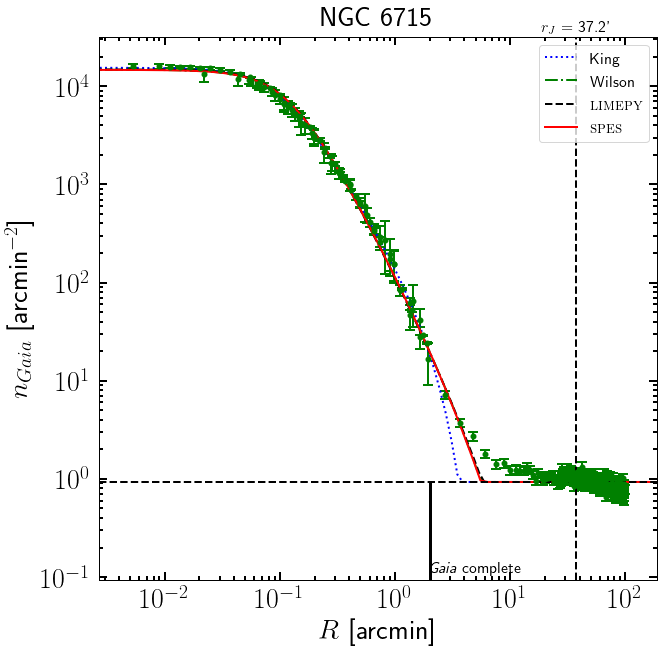


NGC 6717 has 34696.09192 stars
NGC 6717's distance from Sun is 7.10 kpc (Harris 1996, 2010 ed.)
NGC 6717 has Jacobi radius 7.89' (Balbinot & Gieles 2018)



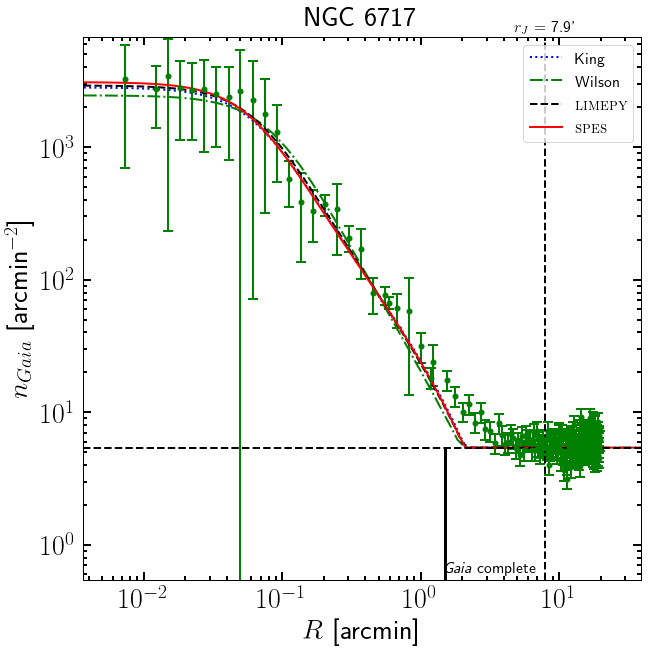


NGC 6723 has 103355.96221 stars
NGC 6723's distance from Sun is 8.70 kpc (Harris 1996, 2010 ed.)
NGC 6723 has Jacobi radius 14.78' (Balbinot & Gieles 2018)



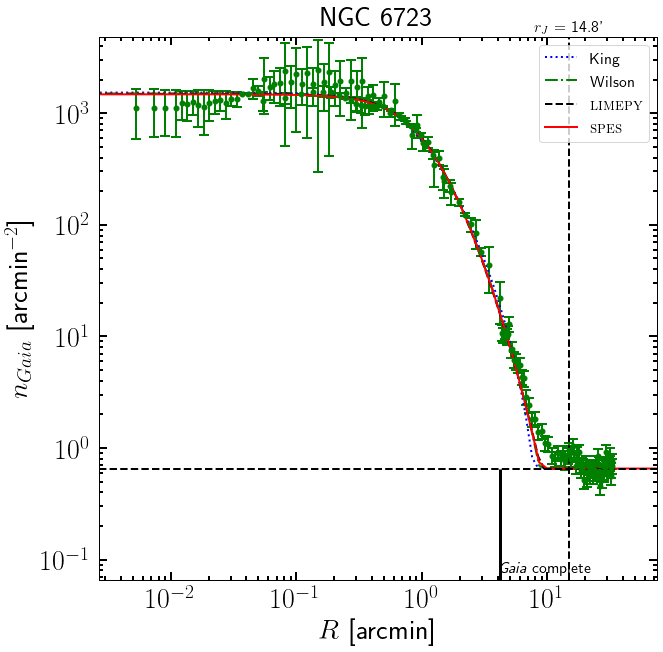


NGC 6752 has 1078099.0426 stars
NGC 6752's distance from Sun is 4.00 kpc (Harris 1996, 2010 ed.)
NGC 6752 has Jacobi radius 54.26' (Balbinot & Gieles 2018)



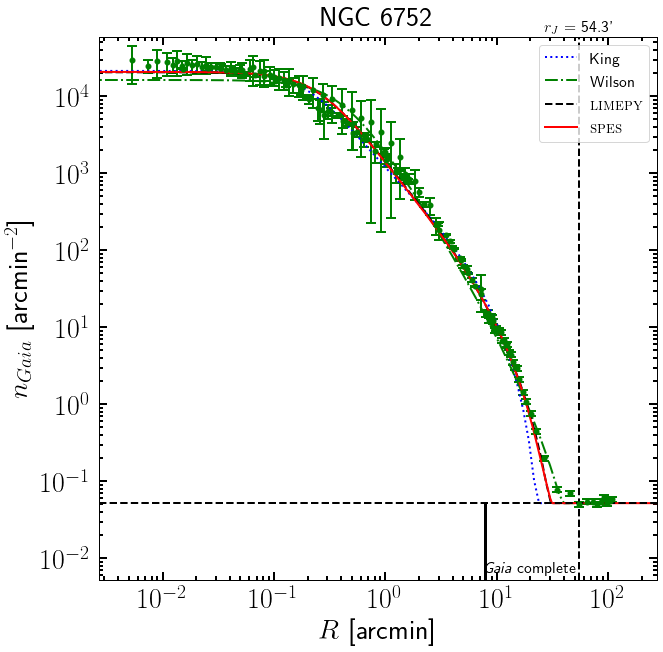


NGC 6779 has 74408.39837 stars
NGC 6779's distance from Sun is 9.40 kpc (Harris 1996, 2010 ed.)
NGC 6779 has Jacobi radius 27.37' (Balbinot & Gieles 2018)



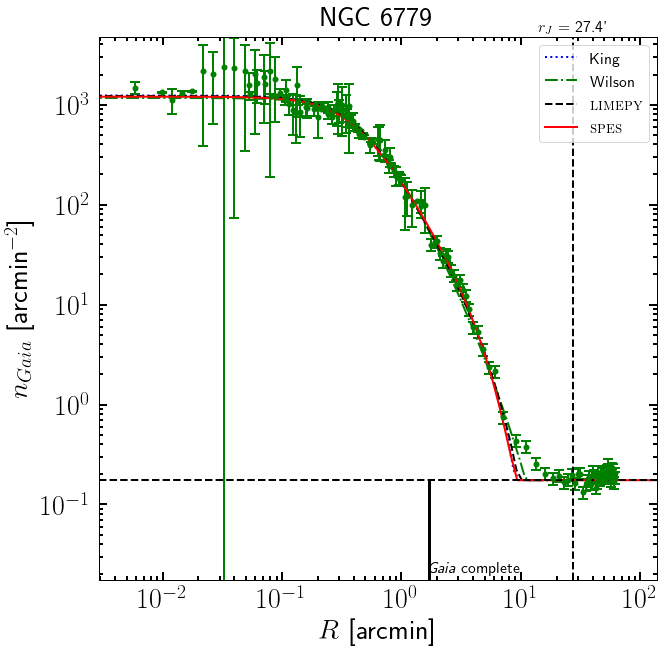


NGC 6809 has 33640.16019999999 stars
NGC 6809's distance from Sun is 5.40 kpc (Harris 1996, 2010 ed.)
NGC 6809 has Jacobi radius 29.60' (Balbinot & Gieles 2018)



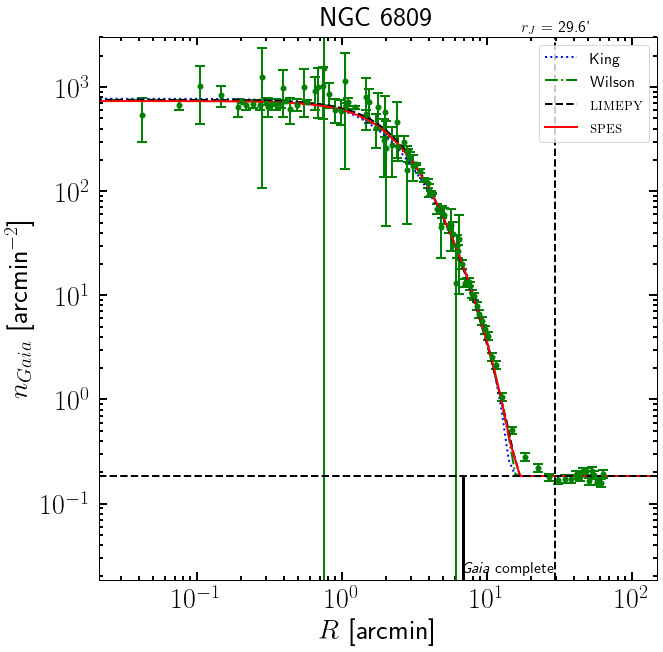


Terzan 8 has 215.97926999999999 stars
Terzan 8's distance from Sun is 26.30 kpc (Harris 1996, 2010 ed.)
Terzan 8 has Jacobi radius 7.93' (Balbinot & Gieles 2018)



ValueError: Image size of 233114x652 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>


Pal 11 has 1067.17095 stars
Pal 11's distance from Sun is 13.40 kpc (Harris 1996, 2010 ed.)
Pal 11 has Jacobi radius 16.28' (Balbinot & Gieles 2018)



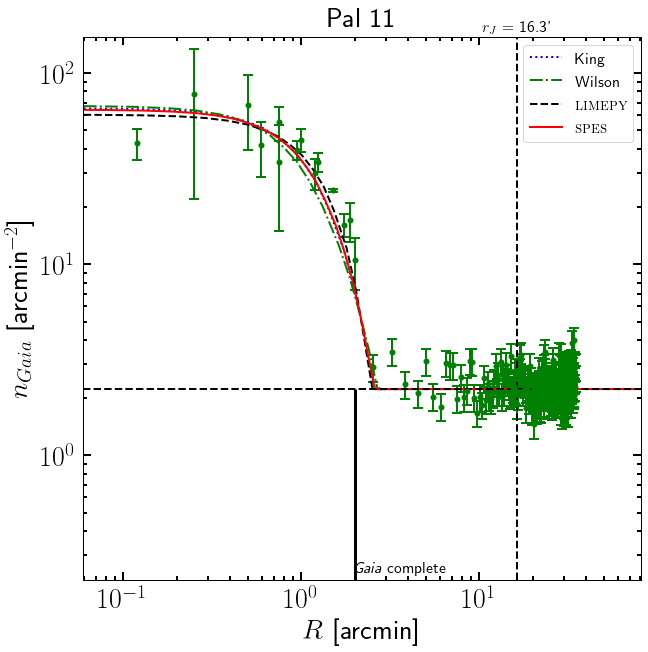


NGC 6864 has 8888.28011 stars
NGC 6864's distance from Sun is 20.90 kpc (Harris 1996, 2010 ed.)
NGC 6864 has Jacobi radius 26.47' (Balbinot & Gieles 2018)



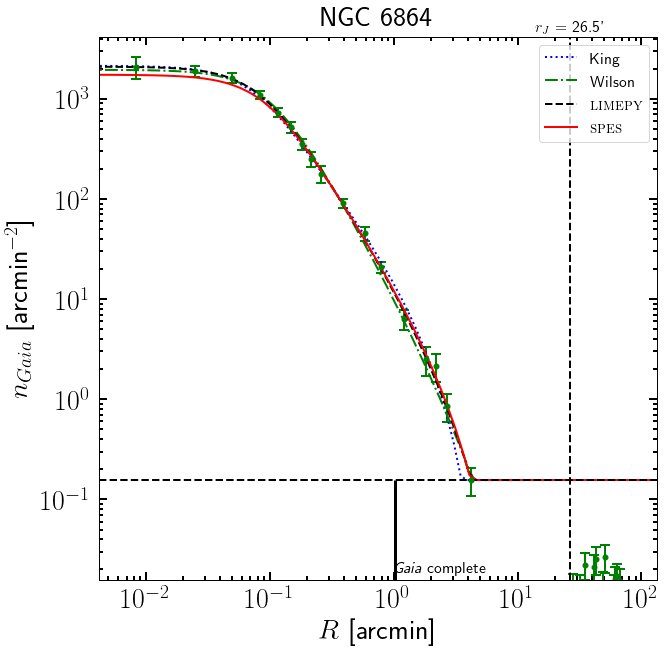


NGC 6934 has 29751.67866 stars
NGC 6934's distance from Sun is 15.60 kpc (Harris 1996, 2010 ed.)
NGC 6934 has Jacobi radius 22.72' (Balbinot & Gieles 2018)



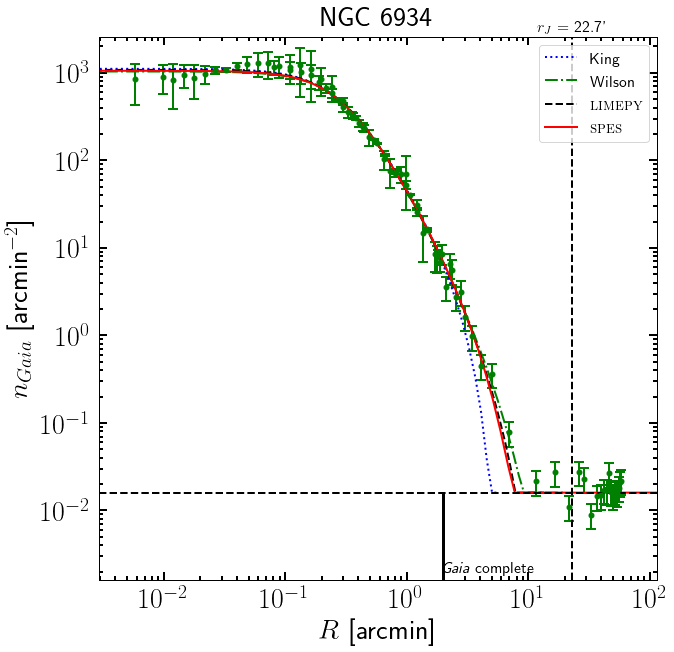


NGC 6981 has 26362.38946 stars
NGC 6981's distance from Sun is 17.00 kpc (Harris 1996, 2010 ed.)
NGC 6981 has Jacobi radius 18.37' (Balbinot & Gieles 2018)



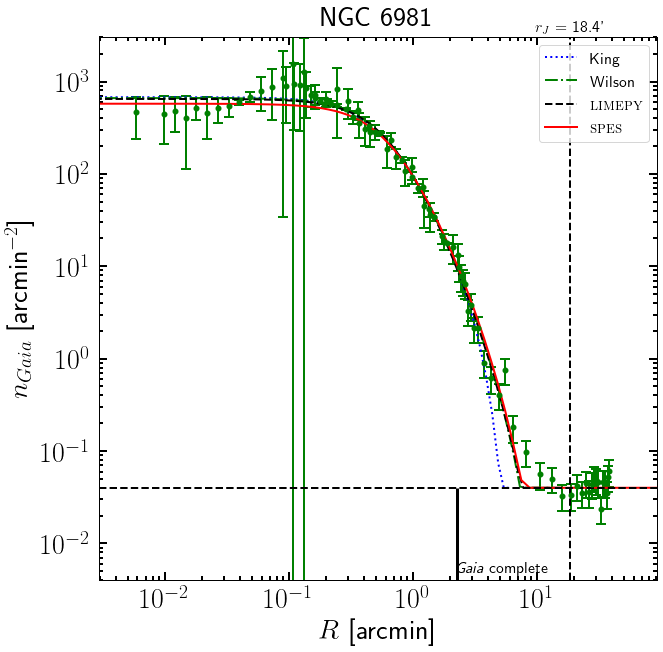


NGC 7006 has 23345.244280000003 stars
NGC 7006's distance from Sun is 41.20 kpc (Harris 1996, 2010 ed.)
NGC 7006 has Jacobi radius 19.46' (Balbinot & Gieles 2018)



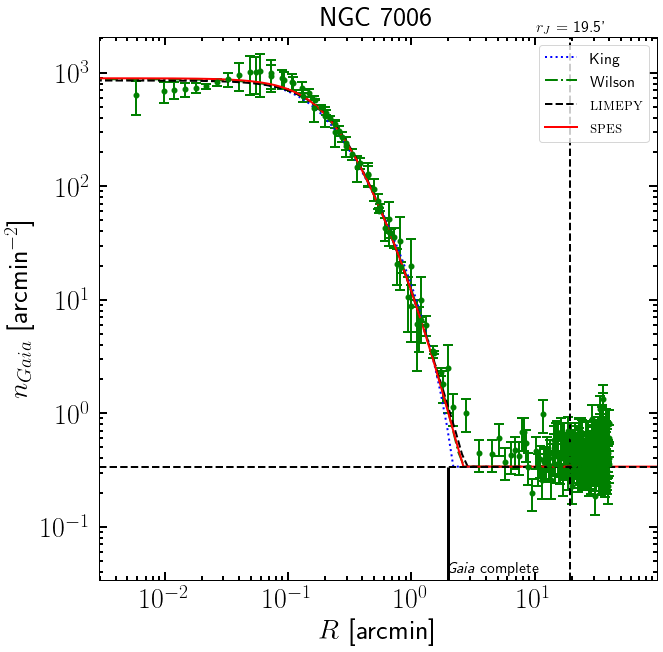


NGC 7078 has 1480281.0359600002 stars
NGC 7078's distance from Sun is 10.40 kpc (Harris 1996, 2010 ed.)
NGC 7078 has Jacobi radius 52.41' (Balbinot & Gieles 2018)



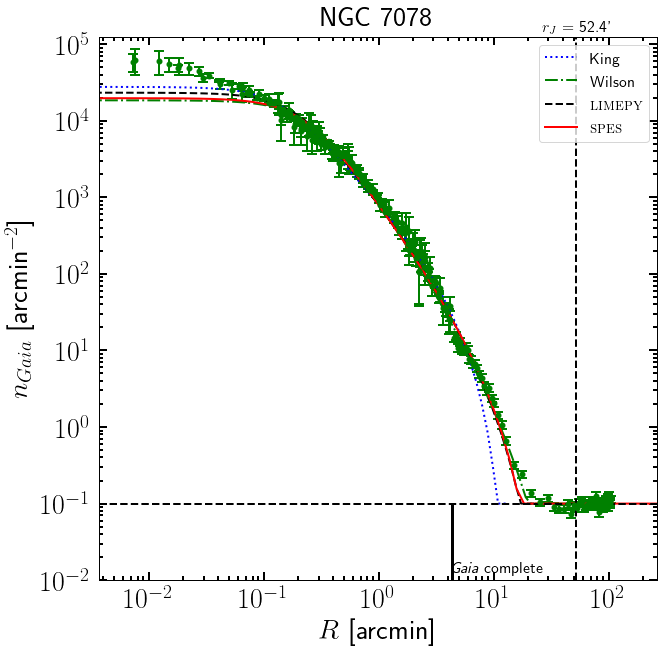


NGC 7089 has 119852.05606 stars
NGC 7089's distance from Sun is 11.50 kpc (Harris 1996, 2010 ed.)
NGC 7089 has Jacobi radius 44.72' (Balbinot & Gieles 2018)



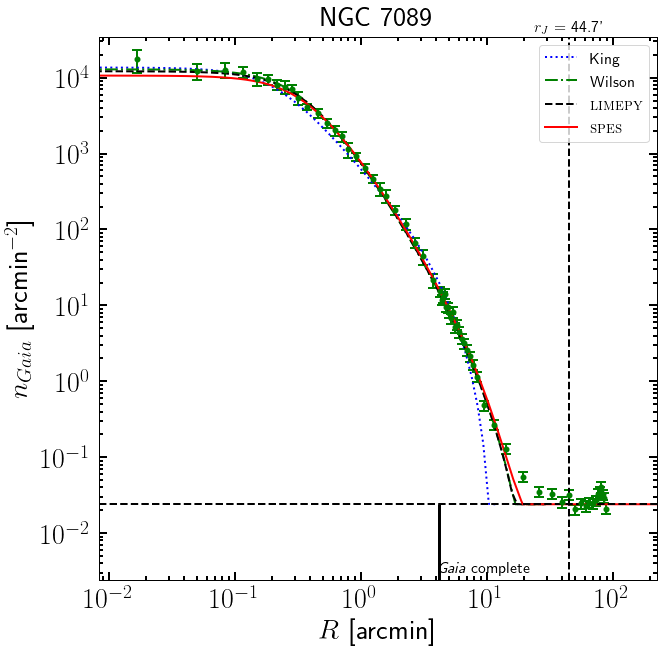


NGC 7099 has 451688.06117000006 stars
NGC 7099's distance from Sun is 8.10 kpc (Harris 1996, 2010 ed.)
NGC 7099 has Jacobi radius 28.80' (Balbinot & Gieles 2018)



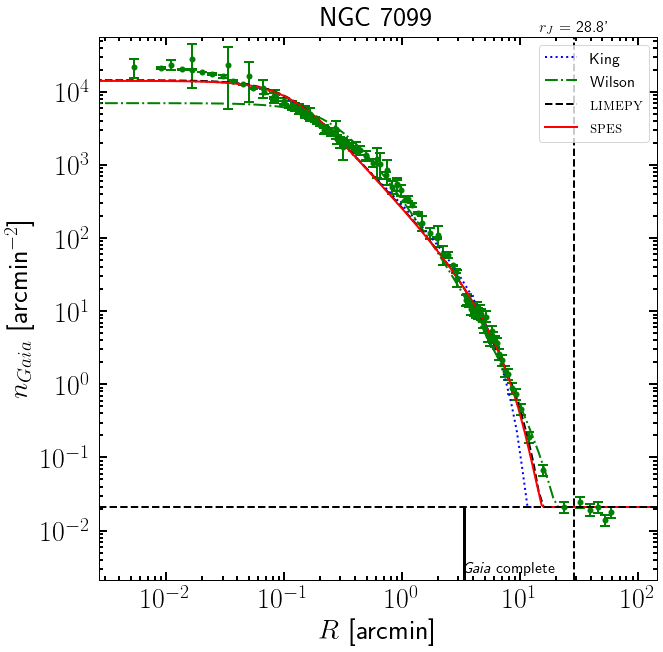


Pal 12 has 5352.11929 stars
Pal 12's distance from Sun is 19.00 kpc (Harris 1996, 2010 ed.)
Pal 12 has Jacobi radius 8.33' (Balbinot & Gieles 2018)



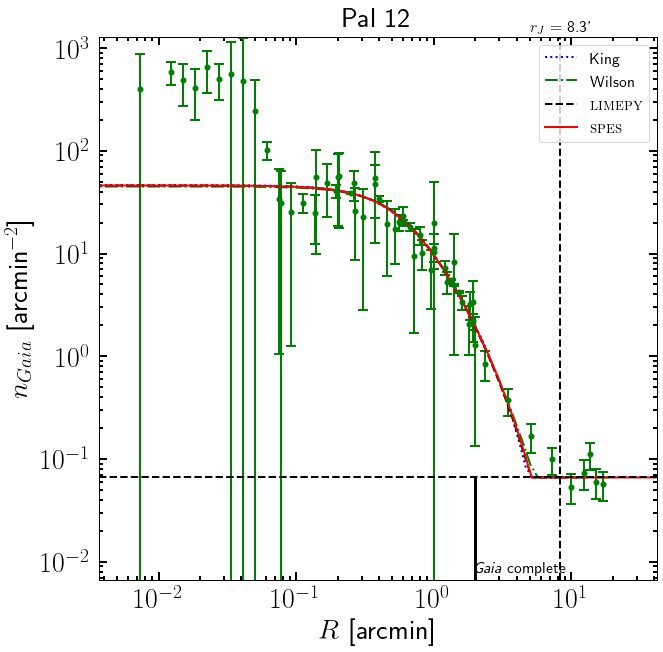


NGC 7492 has 1940.2341799999997 stars
NGC 7492's distance from Sun is 26.30 kpc (Harris 1996, 2010 ed.)
NGC 7492 has Jacobi radius 12.56' (Balbinot & Gieles 2018)



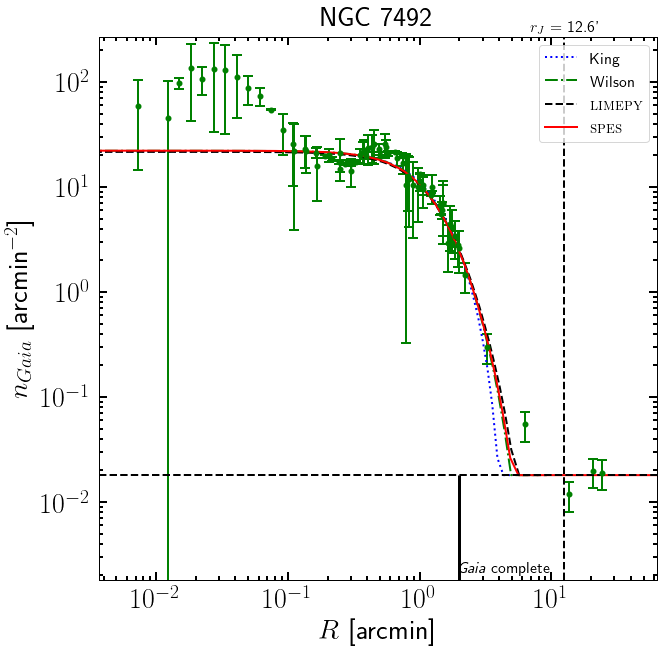

In [12]:
from data.parse_deBoer_2019 import plot_deBoer_2019

for i, fit in enumerate(deB19_fits):
    # if fit["id"] != "NGC 1261": continue
    fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
    fig = plot_deBoer_2019(logger, fit, deB19_stitched, fig=fig)
    pyplot.show(fig)
    
    # if i > 10: break

In [13]:
from amuse.units import units
from amuse.support.console import set_printing_strategy
set_printing_strategy("custom", preferred_units=[
    units.MSun, units.parsec, units.Myr, units.kms],
    precision=2, prefix="", separator=" ", suffix="")

# This repo: src folder /w Python scripts
sys.path.append("../src")
from tlrh_plummer import *
from tlrh_king import *
from tlrh_datamodel import get_radial_profiles
from tlrh_datamodel import plot_radial_profiles
from tlrh_datamodel import scatter_particles_xyz
from tlrh_datamodel import print_particleset_info
from galpy_amuse import setup_cluster
from galpy_amuse import integrate_Nbody_in_MWPotential2014_with_AMUSE

In [14]:
# os.system('ffmpeg -y -r 5 -i "../out/test_%3d.png" -profile:v high444 -level 4.1 -c:v libx264 -preset slow -crf 25 -s "2000:2000" -an "test.mp4"')